In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from scipy.stats import shapiro
from statsmodels.tsa.stattools import kpss
import statsmodels.api as sm

In [216]:
#Reading datasets
liberia = pd.read_csv('liberia.csv')
guinea = pd.read_csv('Guinea.csv')
sierra = pd.read_csv('SierraLeone.csv')

$\textbf{Data Cleaning to eliminate duplicate dates}$

In [219]:
#For Liberia: DROP THE DUPLICATES FROM THE LIBERIA as well as NANs
#Check when the data points stop changing
liberia['Date'] = pd.to_datetime(liberia['Date'])
liberia['Suspected/Confirmed/Probable Cases'] = liberia['Suspected/Confirmed/Probable Cases'].astype(float)
liberia['Suspected/Confirmed/Probable Deaths'] = liberia['Suspected/Confirmed/Probable Deaths'].astype(float)
liberia = liberia[~liberia['Suspected/Confirmed/Probable Cases'].isna()]
liberia = liberia[~np.isinf(liberia['Suspected/Confirmed/Probable Cases'])]

In [221]:
#For Guinea: NO DUPLICATES
guinea['Date'] = pd.to_datetime(guinea['Date'])  
duplicates_guinea = guinea[guinea.duplicated(subset=['Date'], keep=False)]
print(len(duplicates_guinea))

0


In [223]:
#For Sierra Leone: NO DUPLICATES
sierra['Date'] = pd.to_datetime(sierra['Date'])  
#sierra['Year'] = sierra['Date'].dt.year           
duplicates_sierra = sierra[sierra.duplicated(subset=['Date'], keep=False)]

$\textbf{Time Series Analysis}$

$\textbf{Data Exploration: Total Number of Cases}$

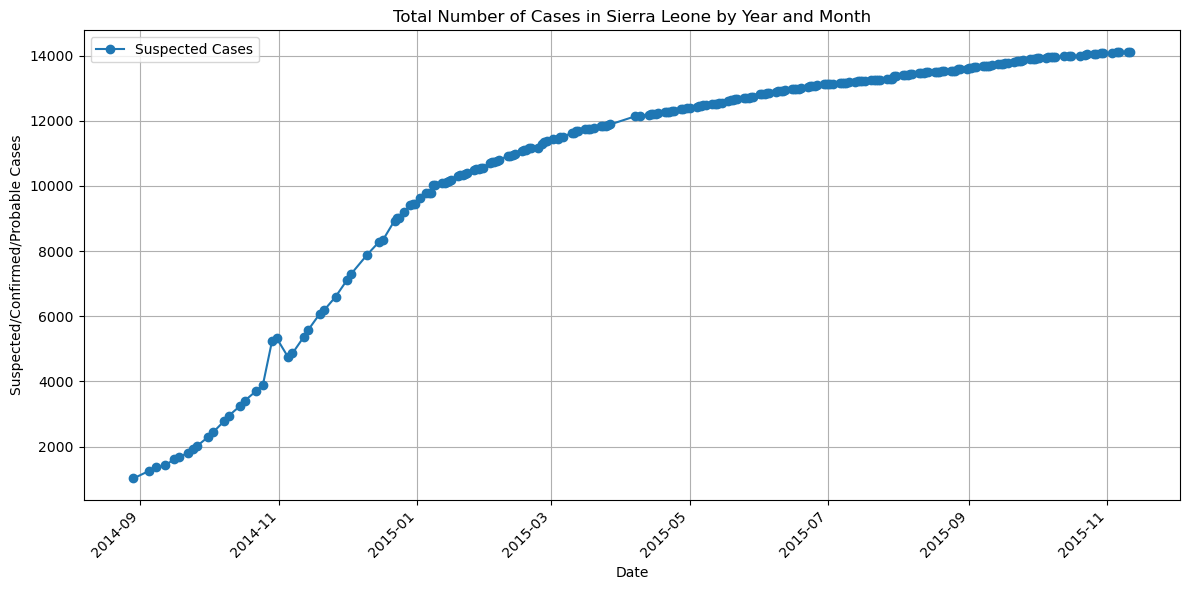

In [227]:
#Total Number of Cases in Sierra Leone 
sierra['Date'] = pd.to_datetime(sierra['Date'], errors='coerce')
plt.figure(figsize=(12, 6))
plt.plot(sierra['Date'], sierra['Suspected/Confirmed/Probable Cases'], marker='o', label='Suspected Cases')
plt.title('Total Number of Cases in Sierra Leone by Year and Month')
plt.xlabel('Date')
plt.ylabel('Suspected/Confirmed/Probable Cases')
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

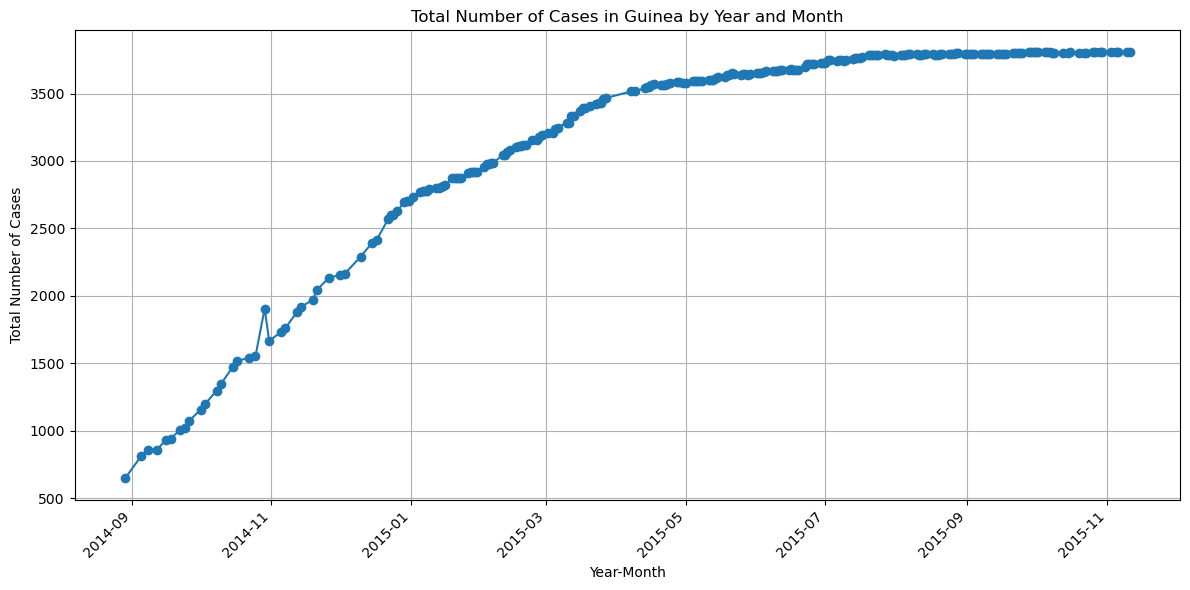

In [228]:
#Total Number of Cases in Guinea
guinea['Date'] = pd.to_datetime(guinea['Date'])
plt.figure(figsize=(12, 6))
plt.plot(guinea['Date'], guinea['Suspected/Confirmed/Probable Cases'], marker='o')
plt.title('Total Number of Cases in Guinea by Year and Month')
plt.xlabel('Year-Month')
plt.ylabel('Total Number of Cases')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid()
plt.show()

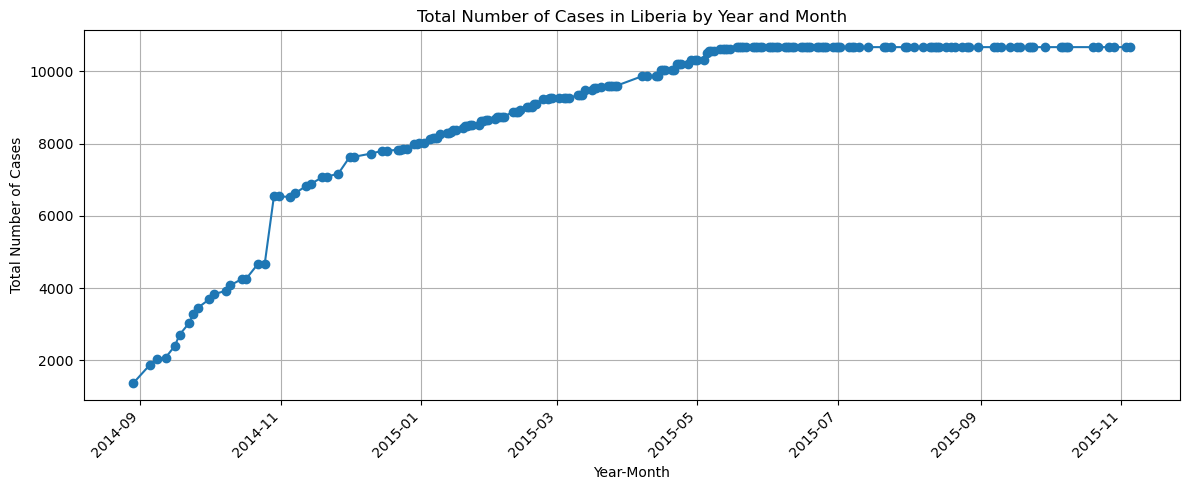

In [231]:
#Total Number of Cases in Liberia
liberia['Date'] = pd.to_datetime(liberia['Date'])
plt.figure(figsize=(12, 5))
plt.plot(liberia['Date'], liberia['Suspected/Confirmed/Probable Cases'], marker='o')
plt.title('Total Number of Cases in Liberia by Year and Month')
plt.xlabel('Year-Month')
plt.ylabel('Total Number of Cases')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid()
plt.show()

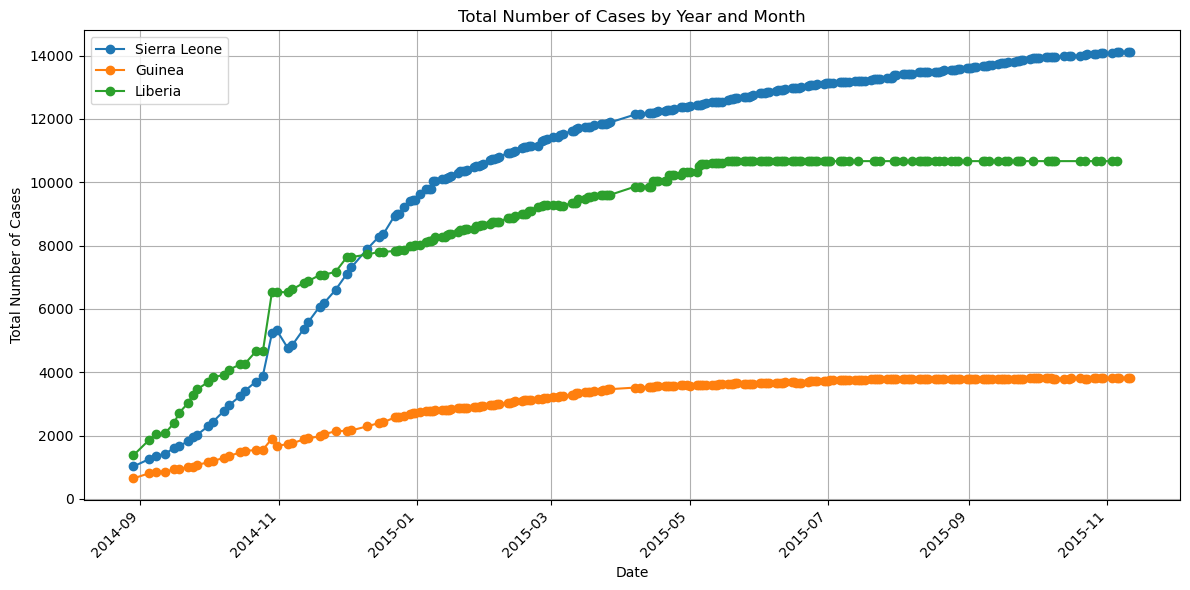

In [232]:
all_countries = [sierra, guinea, liberia]
countries = ['Sierra Leone', 'Guinea', 'Liberia']
plt.figure(figsize=(12, 6))
for i, country_data in enumerate(all_countries):
    plt.plot(
        country_data['Date'],
        country_data['Suspected/Confirmed/Probable Cases'],
        marker='o',
        label=countries[i]
    )
plt.title('Total Number of Cases by Year and Month')
plt.xlabel('Date')
plt.ylabel('Total Number of Cases')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

$\textbf{Auto Correlation Tests for Suspected Total Cases}$

In [236]:
#ACF Tests for Mean Cases
adf_result_s_cases = adfuller(sierra['Suspected/Confirmed/Probable Cases'])
adf_result_lib_cases = adfuller(liberia['Suspected/Confirmed/Probable Cases'])
adf_result_g_cases = adfuller(guinea['Suspected/Confirmed/Probable Cases'])
print("Sierra Leone ADF:", adf_result_s_cases, "Liberia ADF:", adf_result_lib_cases, "Guinea ADF:", adf_result_g_cases)

Sierra Leone ADF: (-4.405638640415365, 0.00029008595545861754, 13, 226, {'1%': -3.4596204846395824, '5%': -2.8744153028455948, '10%': -2.5736320761218576}, 2724.3390309607976) Liberia ADF: (-7.484591775786429, 4.6751674510850975e-11, 1, 196, {'1%': -3.464161278384219, '5%': -2.876401960790147, '10%': -2.5746921001665974}, 2302.4502892032697) Guinea ADF: (-5.199288941683163, 8.821519496668262e-06, 10, 229, {'1%': -3.4592326027153493, '5%': -2.8742454699025872, '10%': -2.5735414688888465}, 2133.0265828291795)


Based on the Augmented Dickey-Fuller test, all three are now stationary.

<Figure size 1500x800 with 0 Axes>

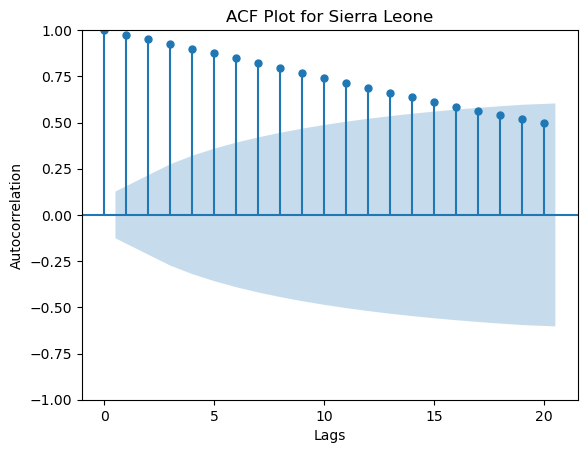

<Figure size 1500x800 with 0 Axes>

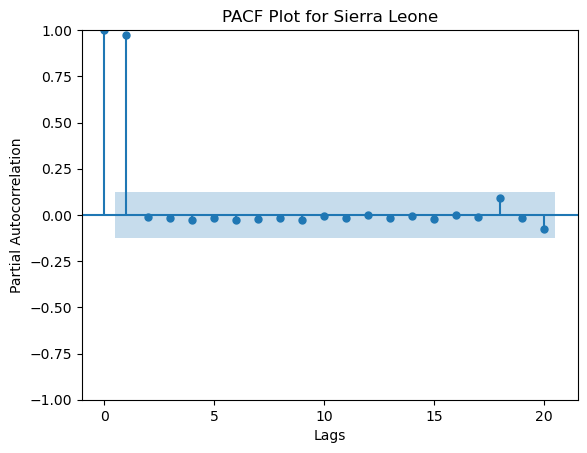

<Figure size 1500x800 with 0 Axes>

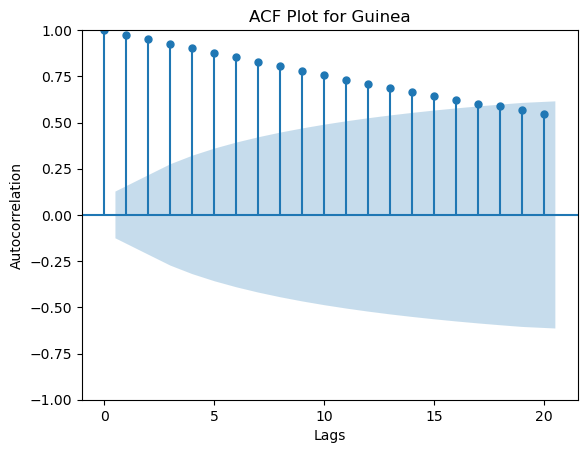

<Figure size 1500x800 with 0 Axes>

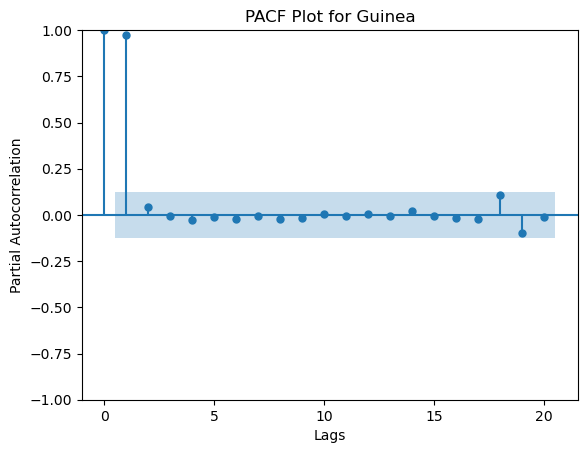

<Figure size 1500x800 with 0 Axes>

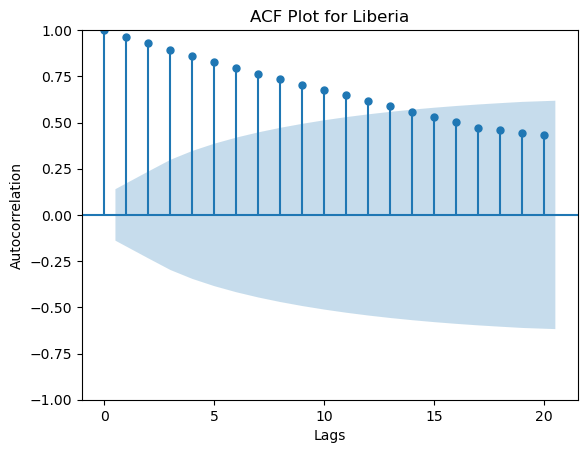

<Figure size 1500x800 with 0 Axes>

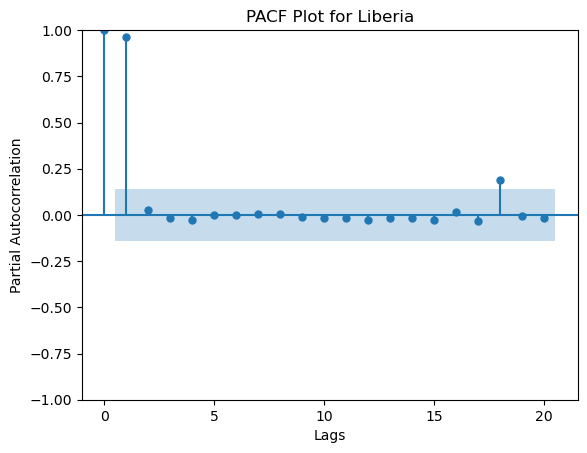

In [239]:
#ACF and PACF Plot for Mean Cases
for i, country_name in enumerate(countries):
    country_data = all_countries[i]
    cases = country_data['Suspected/Confirmed/Probable Cases']    
    max_lags = min(20, len(cases) // 2 - 1)  
    
    # ACF Plot
    plt.figure(figsize=(15, 8))
    plot_acf(cases, lags=max_lags)
    plt.title(f'ACF Plot for {country_name}')
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.show()

    # PACF Plot
    plt.figure(figsize=(15, 8))
    plot_pacf(cases, lags=max_lags, method='ywm')  # You can specify method='ywm' to avoid FutureWarning
    plt.title(f'PACF Plot for {country_name}')
    plt.xlabel('Lags')
    plt.ylabel('Partial Autocorrelation')
    plt.show()

$\textbf{Data Visualizations for Deaths}$

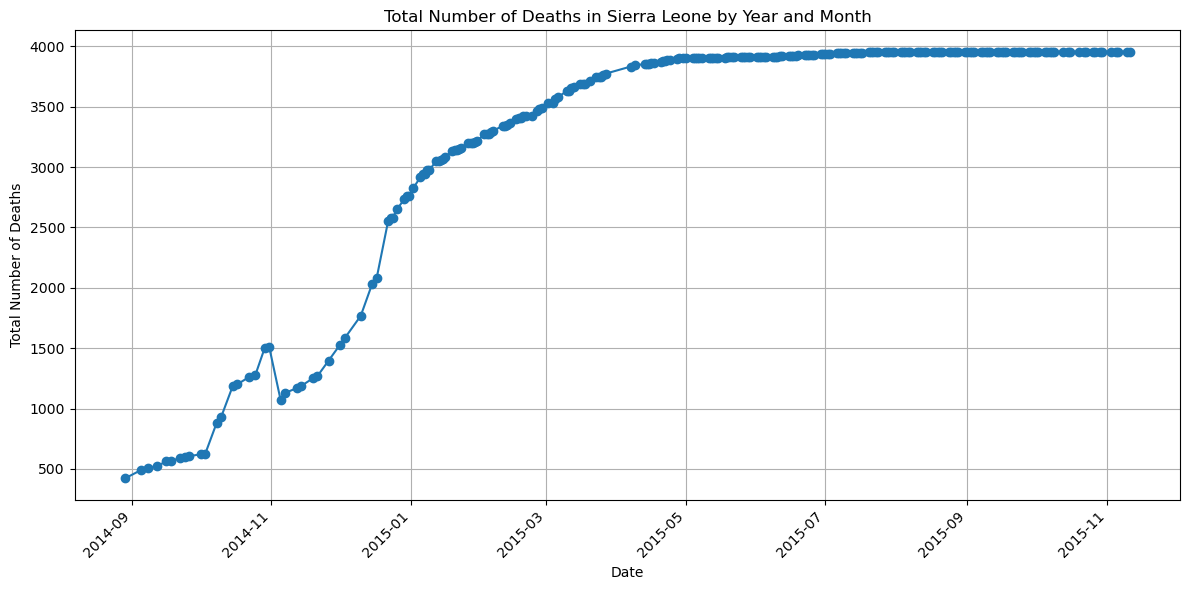

In [242]:
#Total Number of Deaths in Sierra Leone
sierra['Date'] = pd.to_datetime(sierra['Date'])
plt.figure(figsize=(12, 6))
plt.plot(sierra['Date'], sierra['Suspected/Confirmed/Probable Deaths'], marker='o')
plt.title('Total Number of Deaths in Sierra Leone by Year and Month')
plt.xlabel('Date')
plt.ylabel('Total Number of Deaths')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid()
plt.show()

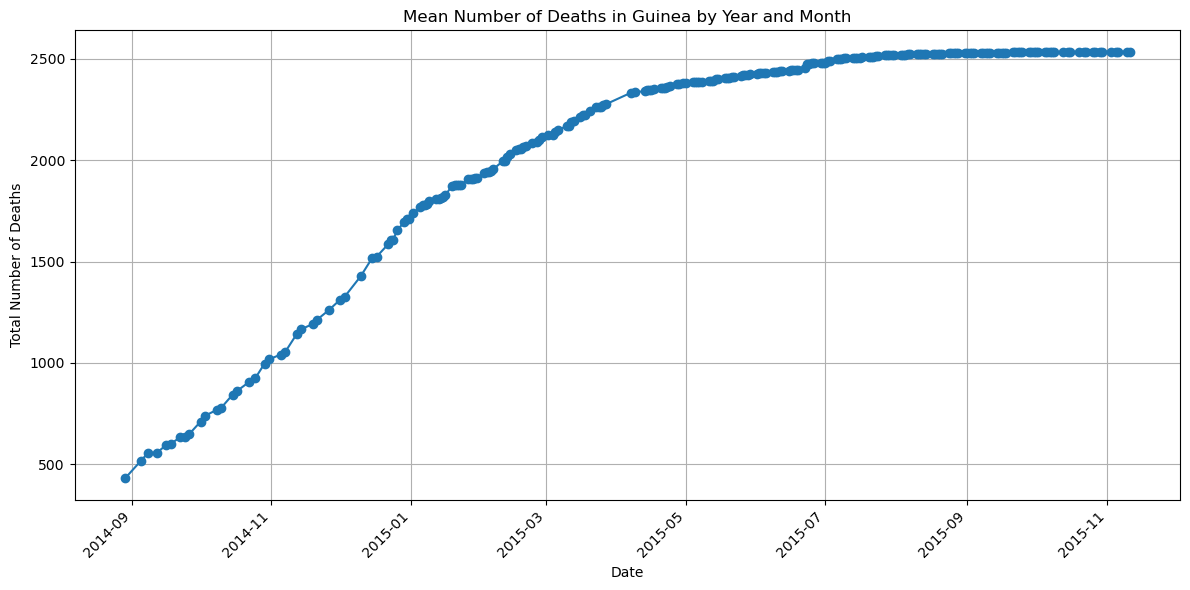

In [244]:
#Total Number of Deaths in Guinea
guinea['Date'] = pd.to_datetime(guinea['Date'])
plt.figure(figsize=(12, 6))
plt.plot(guinea['Date'], guinea['Suspected/Confirmed/Probable Deaths'], marker='o')
plt.title('Mean Number of Deaths in Guinea by Year and Month')
plt.xlabel('Date')
plt.ylabel('Total Number of Deaths')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid()
plt.show()

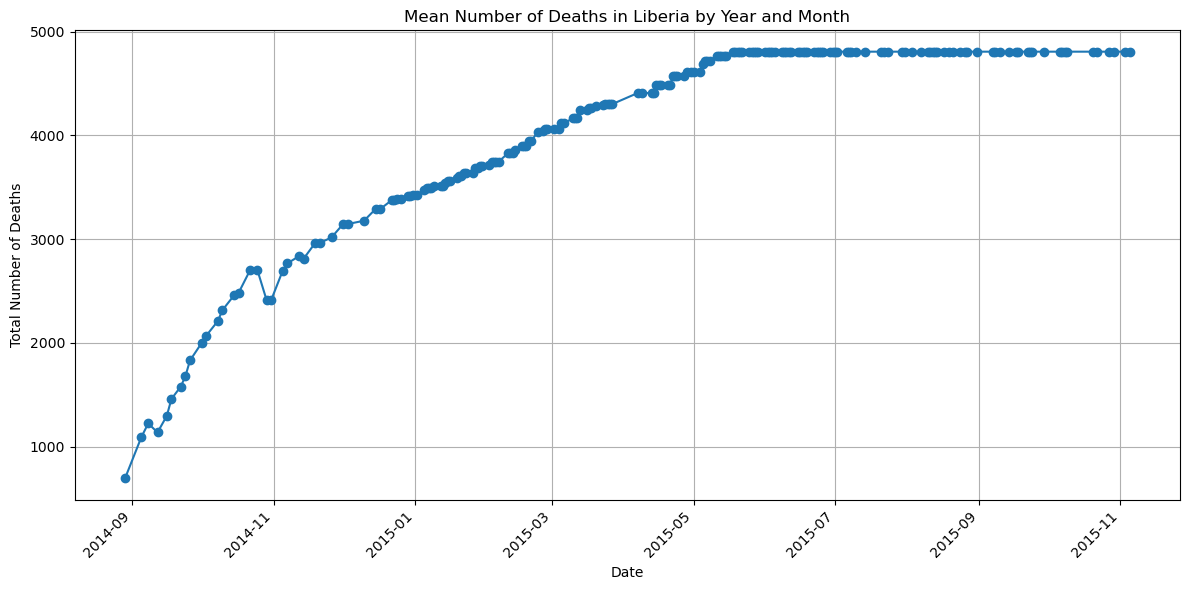

In [246]:
#Total Number of Deaths in Liberia
liberia['Date'] = pd.to_datetime(liberia['Date'])
plt.figure(figsize=(12, 6))
plt.plot(liberia['Date'], liberia['Suspected/Confirmed/Probable Deaths'], marker='o')
plt.title('Mean Number of Deaths in Liberia by Year and Month')
plt.xlabel('Date')
plt.ylabel('Total Number of Deaths')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid()
plt.show()

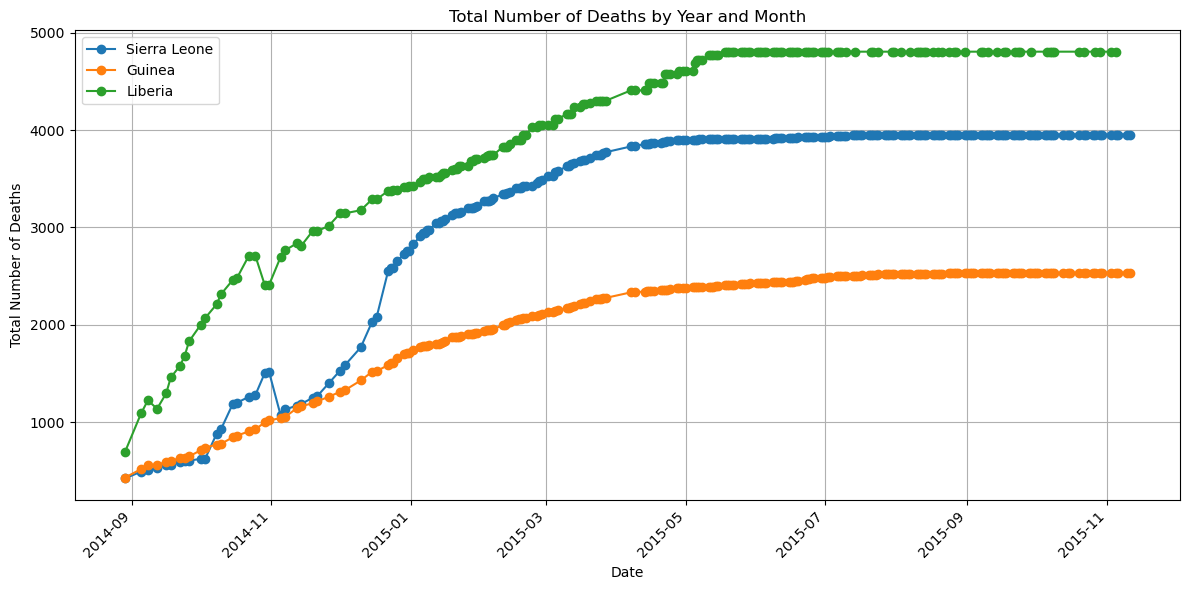

In [248]:
#Combined Plot
all_countries = [sierra, guinea, liberia]
countries = ['Sierra Leone', 'Guinea', 'Liberia']
plt.figure(figsize=(12, 6))
for i, country_data in enumerate(all_countries):
    plt.plot(
        country_data['Date'],
        country_data['Suspected/Confirmed/Probable Deaths'],
        marker='o',
        label=countries[i]
    )
plt.title('Total Number of Deaths by Year and Month')
plt.xlabel('Date')
plt.ylabel('Total Number of Deaths')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid()
plt.legend()
plt.show()

Auto Correlation Plot for Suspected Deaths

In [251]:
#ACF Tests for Mean Deaths
adf_result_s_deaths = adfuller(sierra['Suspected/Confirmed/Probable Deaths'])
adf_result_lib_deaths = adfuller(liberia['Suspected/Confirmed/Probable Deaths'])
adf_result_g_deaths = adfuller(guinea['Suspected/Confirmed/Probable Deaths'])
print("Sierra Leone ADF Deaths:", adf_result_s_deaths, "Liberia ADF Deaths:", 
      adf_result_lib_deaths, "Guinea ADF Deaths:", adf_result_g_deaths)

Sierra Leone ADF Deaths: (-3.460707720524513, 0.009055440331705949, 14, 225, {'1%': -3.4597521044060353, '5%': -2.874472927517147, '10%': -2.5736628197530864}, 2361.8778282204535) Liberia ADF Deaths: (-2.7933830818585537, 0.05922518175731701, 10, 187, {'1%': -3.465811691080702, '5%': -2.877123351472649, '10%': -2.5750770662586864}, 1810.8686617748285) Guinea ADF Deaths: (-4.93111723935704, 3.032335053594025e-05, 4, 235, {'1%': -3.4584868856997004, '5%': -2.873918902362675, '10%': -2.573367247623359}, 1726.9189802869837)


Here, Sierra Leone and Guinea are stationary, whereas Liberia does not have stationary.

<Figure size 1000x500 with 0 Axes>

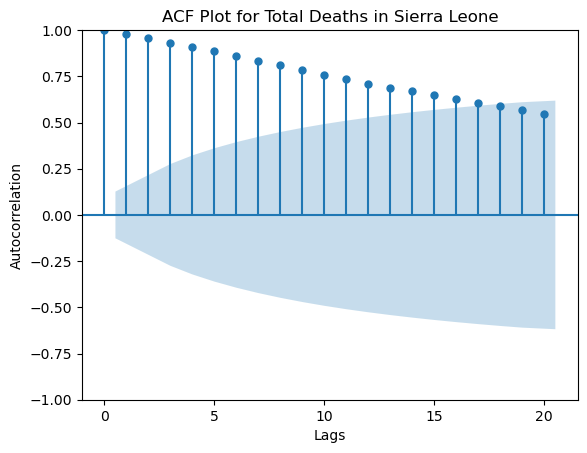

<Figure size 1000x500 with 0 Axes>

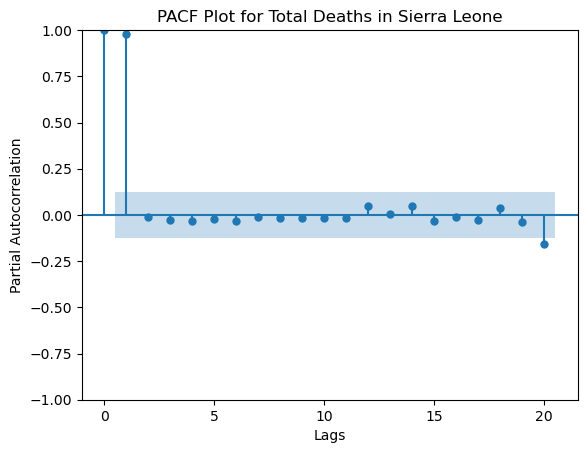

In [254]:
#ACF and PACF plot for Sierra Leone Deaths
cases = sierra['Suspected/Confirmed/Probable Deaths']
num_observations = len(cases)
max_lags = min(20, num_observations // 2 - 1)

# ACF Plot
plt.figure(figsize=(10, 5))
plot_acf(cases, lags=max_lags)
plt.title('ACF Plot for Total Deaths in Sierra Leone')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

# PACF Plot
plt.figure(figsize=(10, 5))
plot_pacf(cases, lags=max_lags, method='ywm')
plt.title('PACF Plot for Total Deaths in Sierra Leone')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

<Figure size 1000x500 with 0 Axes>

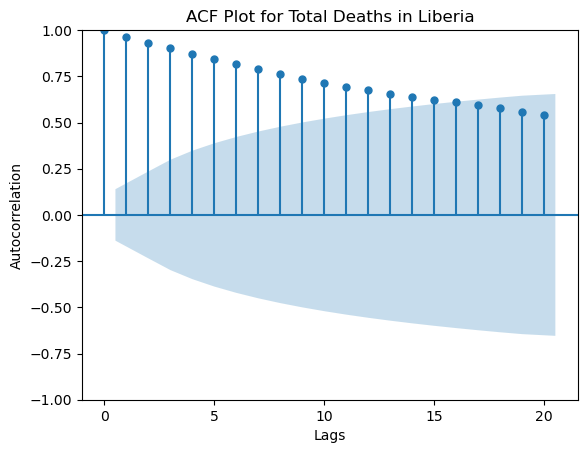

<Figure size 1000x500 with 0 Axes>

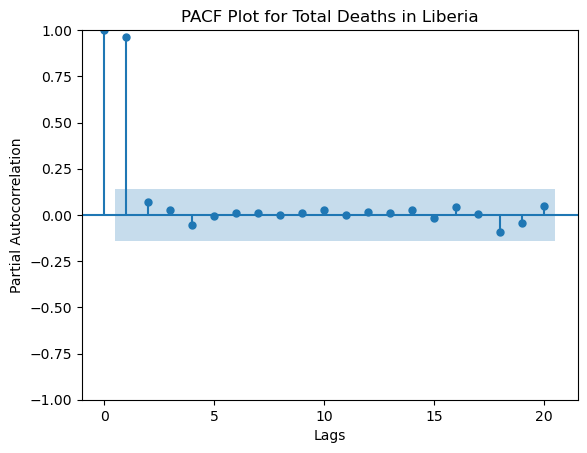

In [256]:
#ACF and PACF plot for Liberia Deaths
cases = liberia['Suspected/Confirmed/Probable Deaths']
num_observations = len(cases)
max_lags = min(20, num_observations // 2 - 1)

# ACF Plot
plt.figure(figsize=(10, 5))
plot_acf(cases, lags=max_lags)
plt.title('ACF Plot for Total Deaths in Liberia')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

# PACF Plot
plt.figure(figsize=(10, 5))
plot_pacf(cases, lags=max_lags, method='ywm')  # Use method='ywm' to avoid warnings
plt.title('PACF Plot for Total Deaths in Liberia')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

<Figure size 1000x500 with 0 Axes>

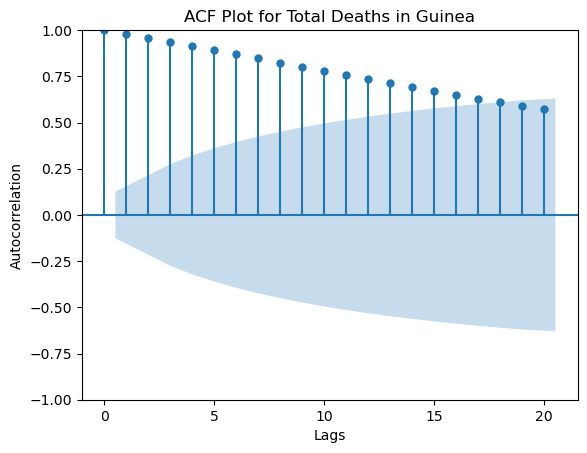

<Figure size 1000x500 with 0 Axes>

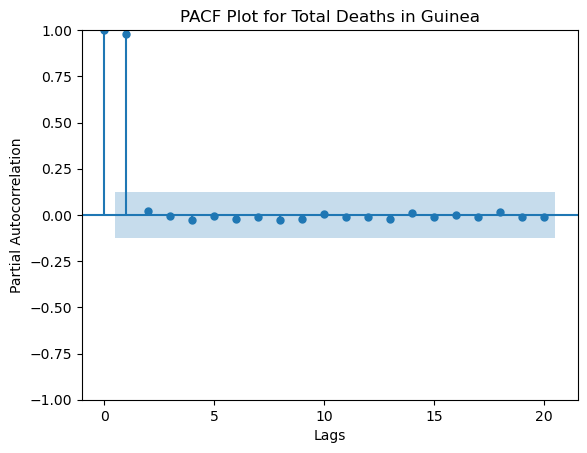

In [258]:
#ACF and PACF Plot for Guinea Deaths
cases = guinea['Suspected/Confirmed/Probable Deaths']
num_observations = len(cases)
max_lags = min(20, num_observations // 2 - 1)

# ACF Plot
plt.figure(figsize=(10, 5))
plot_acf(cases, lags=max_lags)
plt.title('ACF Plot for Total Deaths in Guinea')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

# PACF Plot
plt.figure(figsize=(10, 5))
plot_pacf(cases, lags=max_lags, method='ywm')  # Use method='ywm' to avoid warnings
plt.title('PACF Plot for Total Deaths in Guinea')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

$\textbf{Autoregressive Model (AR) for Monthly Cases}$

C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will co

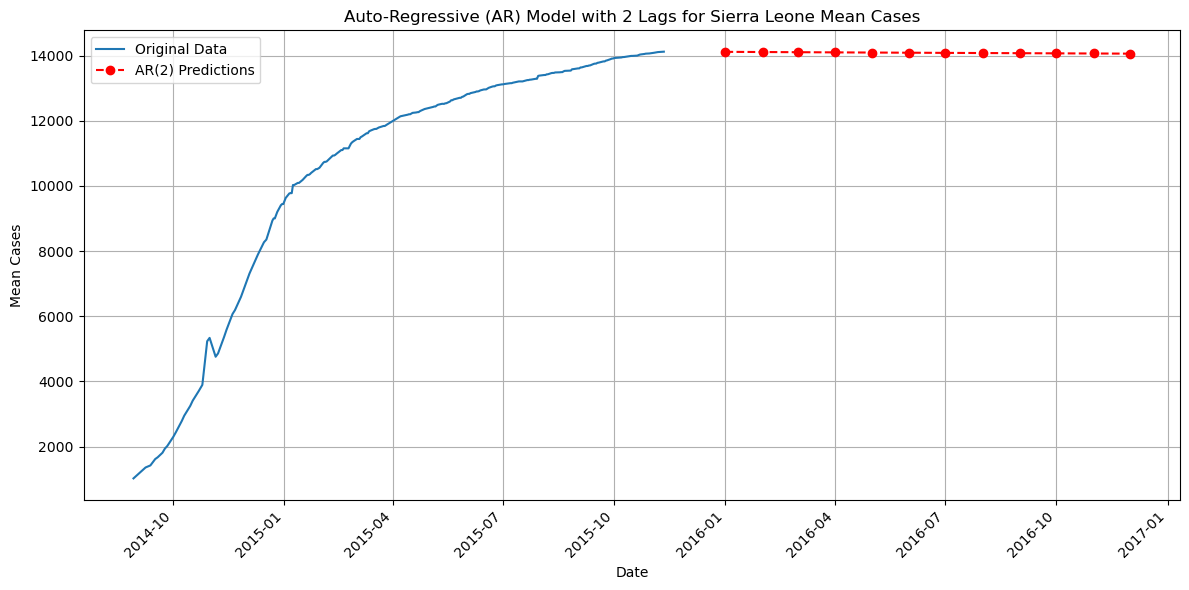

In [261]:
#Autoregressive for Sierra Leone Monthly Cases
sierra = sierra.dropna(subset=['Date'])
sierra.set_index('Date', inplace=True)
sierra = sierra[sierra.index.year > 1970]
model_ar_s_cases = AutoReg(sierra['Suspected/Confirmed/Probable Cases'], lags=2) #Lags 2 chosen based PACF plot
model_ar_s_cases_fit = model_ar_s_cases.fit()
forecast_steps = 12
predictions_ar_s_cases = model_ar_s_cases_fit.predict(
    start=len(sierra), 
    end=len(sierra) + forecast_steps - 1
)
last_date_ar_s_cases = pd.to_datetime(sierra.index[-1])
forecast_index_ar_s_cases = pd.date_range(
    start=last_date_ar_s_cases + pd.DateOffset(months=1), 
    periods=forecast_steps, 
    freq='MS'
)
plt.figure(figsize=(12, 6))
plt.plot(sierra.index, sierra['Suspected/Confirmed/Probable Cases'], label='Original Data')
plt.plot(forecast_index_ar_s_cases, predictions_ar_s_cases, color='red', linestyle='dashed', marker='o', label='AR(2) Predictions')
plt.title('Auto-Regressive (AR) Model with 2 Lags for Sierra Leone Mean Cases')
plt.xlabel('Date')
plt.ylabel('Mean Cases')
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will co

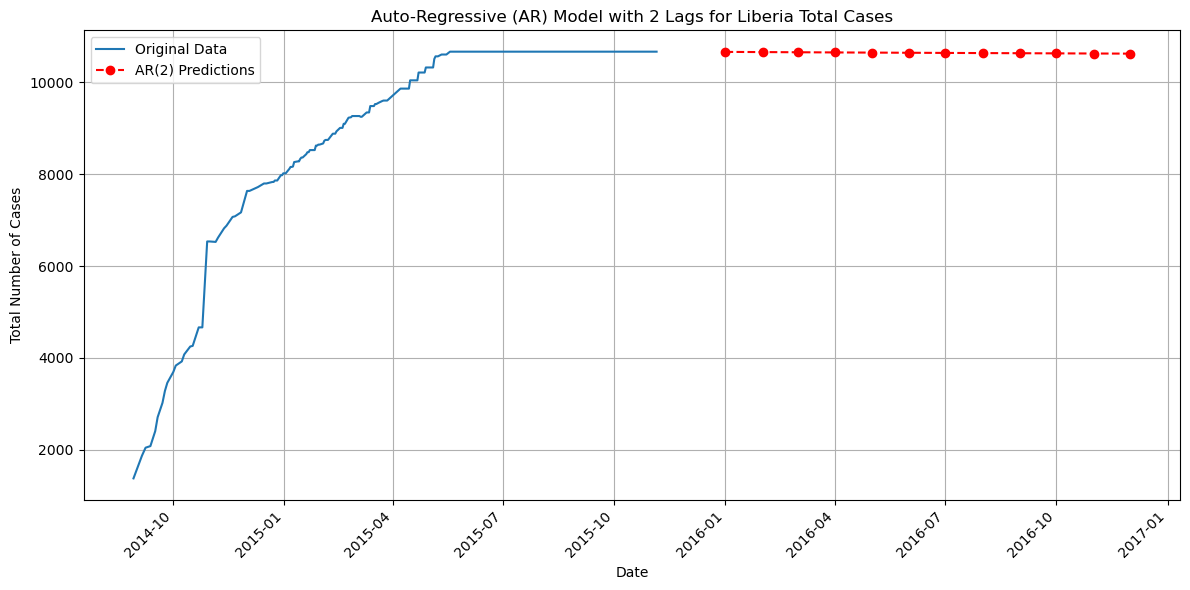

In [263]:
#Autoregressive for Liberia Total Cases
if 'Date' in liberia.columns:
    liberia['Date'] = pd.to_datetime(liberia['Date'], errors='coerce')
    liberia = liberia.dropna(subset=['Date'])
    liberia.set_index('Date', inplace=True)
liberia = liberia[liberia.index.year > 1970]
model_ar_l_cases = AutoReg(liberia['Suspected/Confirmed/Probable Cases'], lags=2)
model_ar_l_cases_fit = model_ar_l_cases.fit()
forecast_steps = 12
predictions_ar_l_cases = model_ar_l_cases_fit.predict(start=len(liberia), end=len(liberia) + forecast_steps - 1)
last_date_ar_l_cases = pd.to_datetime(liberia.index[-1])
forecast_index_ar_l_cases = pd.date_range(start=last_date_ar_l_cases + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
plt.figure(figsize=(12, 6))
plt.plot(liberia.index, liberia['Suspected/Confirmed/Probable Cases'], label='Original Data')
plt.plot(forecast_index_ar_l_cases, predictions_ar_l_cases, color='red', linestyle='dashed', marker='o', label='AR(2) Predictions')
plt.title('Auto-Regressive (AR) Model with 2 Lags for Liberia Total Cases')
plt.xlabel('Date')
plt.ylabel('Total Number of Cases')
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will co

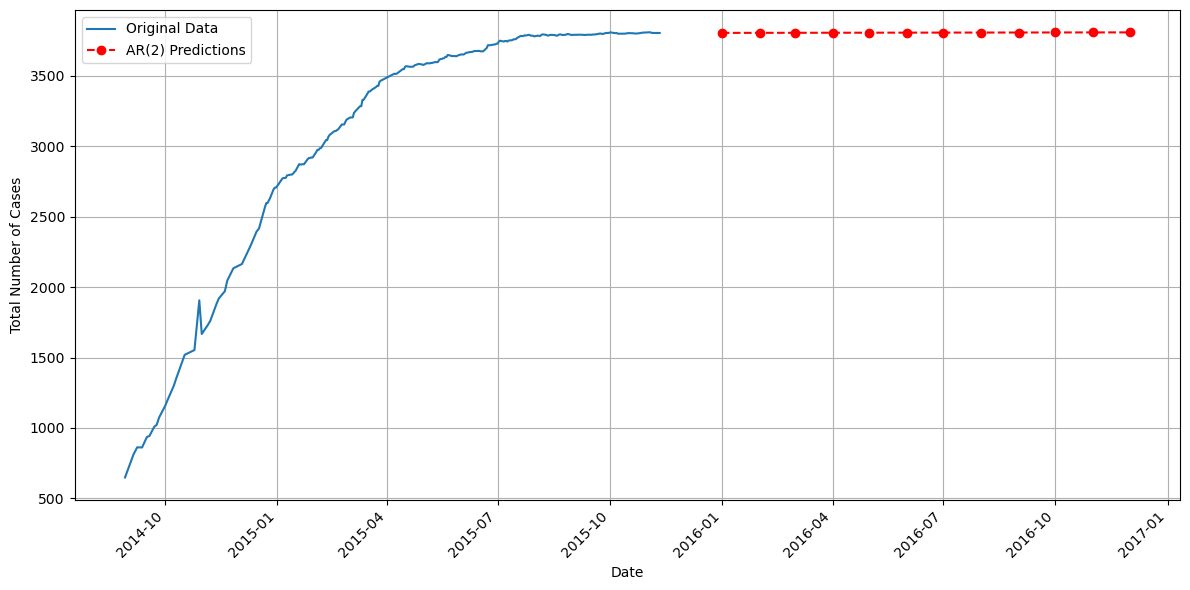

In [265]:
#Guinea  AR Modeling: Monthly Total Cases
#Checking for Date Errors
if 'Date' in guinea.columns:
    guinea['Date'] = pd.to_datetime(guinea['Date'], errors='coerce')
    guinea = guinea.dropna(subset=['Date'])
    guinea.set_index('Date', inplace=True)
guinea = guinea[guinea.index.year > 1970]
model_ar_g_cases = AutoReg(guinea['Suspected/Confirmed/Probable Cases'], lags=2)
model_ar_g_cases_fit = model_ar_g_cases.fit()
forecast_steps = 12
predictions_ar_g_cases = model_ar_g_cases_fit.predict(
    start=len(guinea), 
    end=len(guinea) + forecast_steps - 1
)
last_date_ar_g_cases = guinea.index[-1]
forecast_index_ar_g_cases = pd.date_range(
    start=last_date_ar_g_cases + pd.DateOffset(months=1), 
    periods=forecast_steps, 
    freq='MS'
)
plt.figure(figsize=(12, 6))
plt.plot(guinea.index, guinea['Suspected/Confirmed/Probable Cases'], label='Original Data')
plt.plot(forecast_index_ar_g_cases, predictions_ar_g_cases, color='red', linestyle='dashed', marker='o', label='AR(2) Predictions')
plt.xlabel('Date')
plt.ylabel('Total Number of Cases')
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

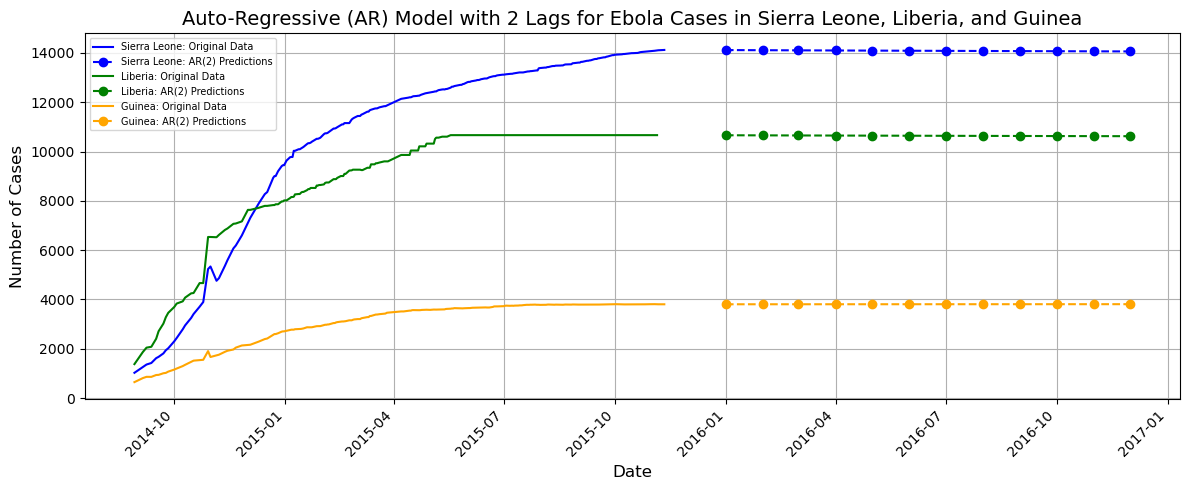

In [267]:
#Combined Figures for all three AR models for Monthly Cases
plt.figure(figsize=(12, 5))
plt.plot(sierra.index, sierra['Suspected/Confirmed/Probable Cases'], label='Sierra Leone: Original Data', color='blue')
plt.plot(forecast_index_ar_s_cases, predictions_ar_s_cases, color='blue', linestyle='dashed', marker='o', label='Sierra Leone: AR(2) Predictions')
plt.plot(liberia.index, liberia['Suspected/Confirmed/Probable Cases'], label='Liberia: Original Data', color='green')
plt.plot(forecast_index_ar_l_cases, predictions_ar_l_cases, color='green', linestyle='dashed', marker='o', label='Liberia: AR(2) Predictions')
plt.plot(guinea.index, guinea['Suspected/Confirmed/Probable Cases'], label='Guinea: Original Data', color='orange')
plt.plot(forecast_index_ar_g_cases, predictions_ar_g_cases, color='orange', linestyle='dashed', marker='o', label='Guinea: AR(2) Predictions')
plt.title('Auto-Regressive (AR) Model with 2 Lags for Ebola Cases in Sierra Leone, Liberia, and Guinea', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(loc='upper left', fontsize=7)
plt.grid()
plt.tight_layout()
plt.show()

$\textbf{Model Diagnostics Autoregressive Model (AR) for Total Cases}$

In [270]:
#Residual Extractions
resid_ar_s_cases = model_ar_s_cases_fit.resid
resid_ar_l_cases = model_ar_l_cases_fit.resid
resid_ar_g_cases = model_ar_g_cases_fit.resid

In [272]:
#For Sierra Leone AR Model Diagnostics
print(acorr_ljungbox(resid_ar_s_cases, lags=[2], return_df=True)) #Autocorrelation Testing: No significant correlation at the tested lags
print(shapiro(resid_ar_s_cases)) #Normality Testing: Not Normally Distributed
print(het_breuschpagan(resid_ar_s_cases, sm.add_constant(model_ar_s_cases_fit.fittedvalues))) #Presence of heteroscedasticity

    lb_stat  lb_pvalue
2  6.999432   0.030206
ShapiroResult(statistic=0.53252774477005, pvalue=9.41985808064944e-25)
(19.325303059364014, 1.1023581130753774e-05, 20.856420911140106, 7.97535163194224e-06)


In [274]:
#For Liberia AR Model Diagnostics
print(acorr_ljungbox(resid_ar_l_cases, lags=[3], return_df=True)) #Autocorrelation Testing: No significant correlation at the tested lags
print(shapiro(resid_ar_l_cases)) #Normality Testing: Not Normally Distributed
print(het_breuschpagan(resid_ar_l_cases, sm.add_constant(model_ar_l_cases_fit.fittedvalues))) #Presence of heteroscedasticity

    lb_stat  lb_pvalue
3  1.020215   0.796361
ShapiroResult(statistic=0.3500465154647827, pvalue=5.704170005479539e-26)
(6.025173975563211, 0.014103241518622762, 6.15283496092745, 0.013971596038093254)


In [276]:
#For Guinea AR Model Diagnostics
print(acorr_ljungbox(resid_ar_g_cases, lags=[2], return_df=True)) #Autocorrelation Testing: No significant correlation at the tested lags
print(shapiro(resid_ar_g_cases)) #Normality Testing: Not normally distributed
print(het_breuschpagan(resid_ar_g_cases, sm.add_constant(model_ar_g_cases_fit.fittedvalues))) #No heteroscedasticity

    lb_stat  lb_pvalue
2  1.932429   0.380521
ShapiroResult(statistic=0.6096384525299072, pvalue=6.429345750739702e-23)
(19.83273545328422, 8.452267885858136e-06, 21.453839909024676, 5.991557199856064e-06)


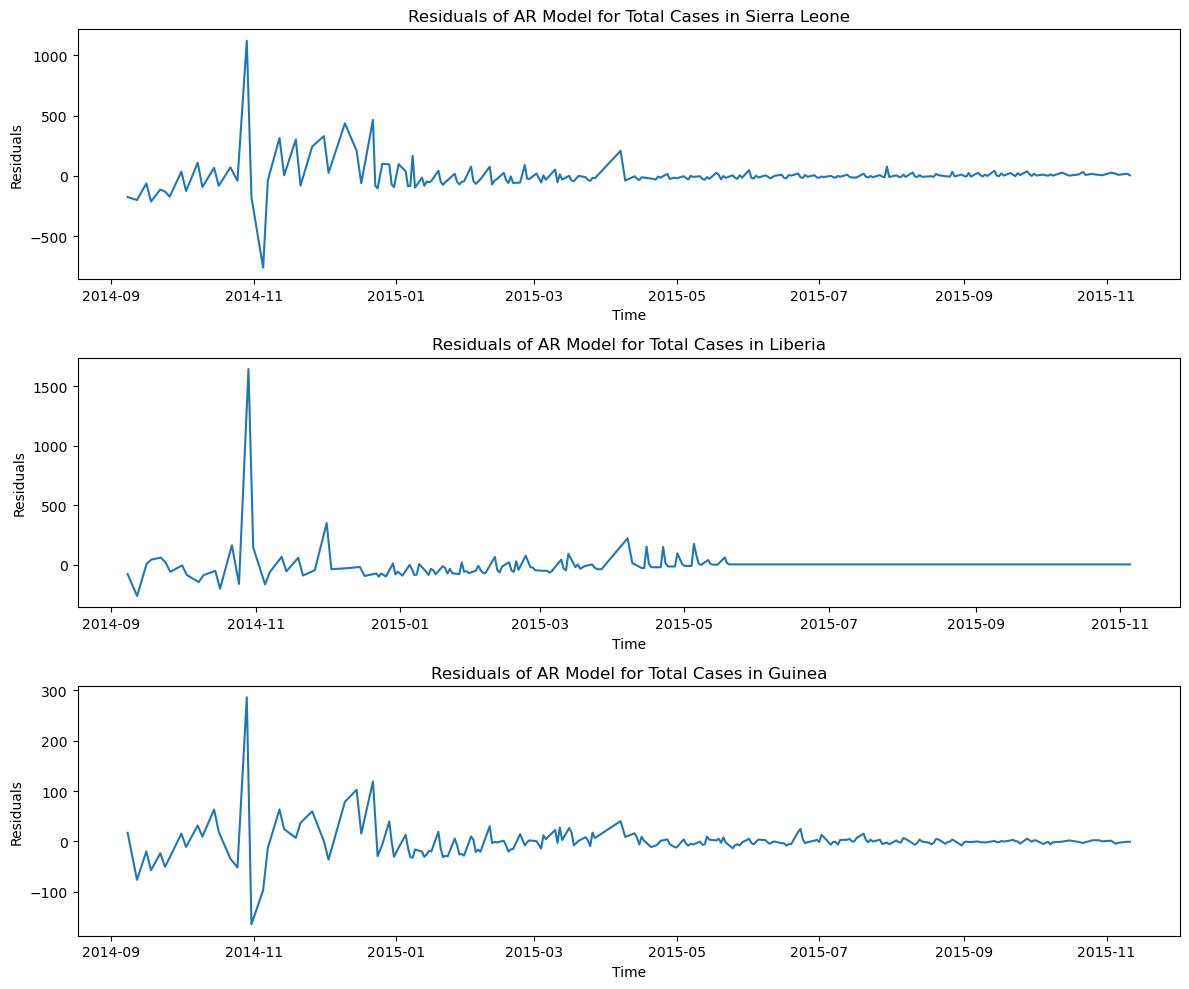

In [278]:
#Plotting Residuals
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
plt.plot(resid_ar_s_cases)
plt.title('Residuals of AR Model for Total Cases in Sierra Leone')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.subplot(3, 1, 2)
plt.plot(resid_ar_l_cases)
plt.title('Residuals of AR Model for Total Cases in Liberia')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.subplot(3, 1, 3)
plt.plot(resid_ar_g_cases)
plt.title('Residuals of AR Model for Total Cases in Guinea')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

$\textbf{Autoregressive Model (AR) for Monthly Total Deaths}$

C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will co

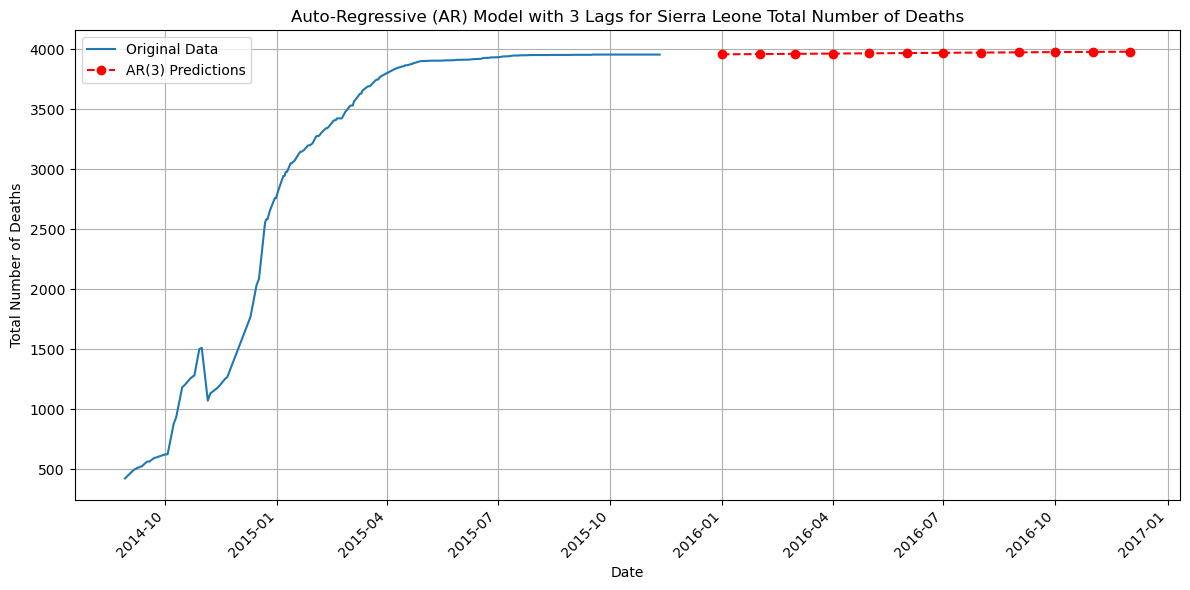

In [140]:
#Sierra Leone AR Modeling: Monthly Death Cases
if 'Date' in sierra.columns:
    sierra['Date'] = pd.to_datetime(sierra['Date'], errors='coerce')
    sierra = sierra.dropna(subset=['Date'])
    sierra.set_index('Date', inplace=True)
sierra = sierra[sierra.index.year > 1970]
model_ar_s_deaths = AutoReg(sierra['Suspected/Confirmed/Probable Deaths'], lags=3)
model_ar_s_deaths_fit = model_ar_s_deaths.fit()

forecast_steps = 12
predictions_ar_s_deaths = model_ar_s_deaths_fit.predict(
    start=len(sierra), 
    end=len(sierra) + forecast_steps - 1
)

last_date_ar_s_deaths = sierra.index[-1]
forecast_index_ar_s_deaths = pd.date_range(
    start=last_date_ar_s_deaths + pd.DateOffset(months=1), 
    periods=forecast_steps, 
    freq='MS'
)

plt.figure(figsize=(12, 6))
plt.plot(sierra.index, sierra['Suspected/Confirmed/Probable Deaths'], label='Original Data')
plt.plot(forecast_index_ar_s_deaths, predictions_ar_s_deaths, color='red', linestyle='dashed', marker='o', label='AR(3) Predictions')
plt.title('Auto-Regressive (AR) Model with 3 Lags for Sierra Leone Total Number of Deaths')
plt.xlabel('Date')
plt.ylabel('Total Number of Deaths')
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will co

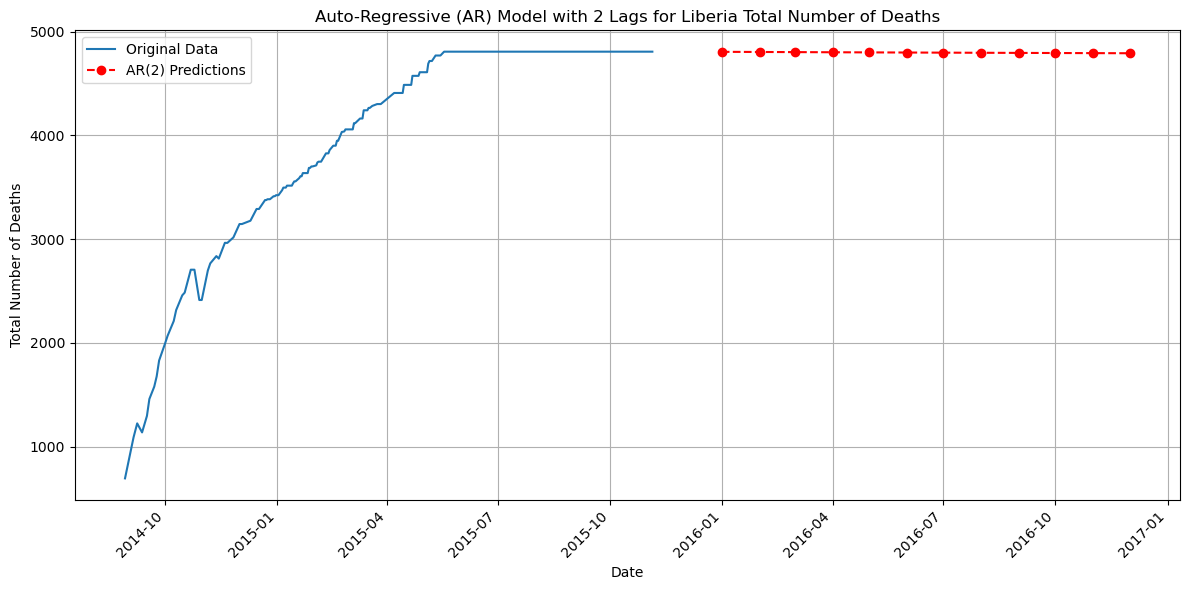

In [142]:
#Liberia AR Modeling: Monthly Death Cases
if 'Date' in liberia.columns:
    liberia['Date'] = pd.to_datetime(liberia['Date'], errors='coerce')
    liberia = liberia.dropna(subset=['Date'])
    liberia.set_index('Date', inplace=True)
liberia = liberia[liberia.index.year > 1970]
model_ar_lib_deaths = AutoReg(liberia['Suspected/Confirmed/Probable Deaths'], lags=2)
model_ar_lib_deaths_fit = model_ar_lib_deaths.fit()
forecast_steps = 12
predictions_ar_l_deaths = model_ar_lib_deaths_fit.predict(
    start=len(liberia), 
    end=len(liberia) + forecast_steps - 1
)
last_date_ar_l_deaths = liberia.index[-1]
forecast_index_ar_l_deaths = pd.date_range(
    start=last_date_ar_l_deaths + pd.DateOffset(months=1), 
    periods=forecast_steps, 
    freq='MS'
)
plt.figure(figsize=(12, 6))
plt.plot(liberia.index, liberia['Suspected/Confirmed/Probable Deaths'], label='Original Data')
plt.plot(forecast_index_ar_l_deaths, predictions_ar_l_deaths, color='red', linestyle='dashed', marker='o', label='AR(2) Predictions')
plt.title('Auto-Regressive (AR) Model with 2 Lags for Liberia Total Number of Deaths')
plt.xlabel('Date')
plt.ylabel('Total Number of Deaths')
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will co

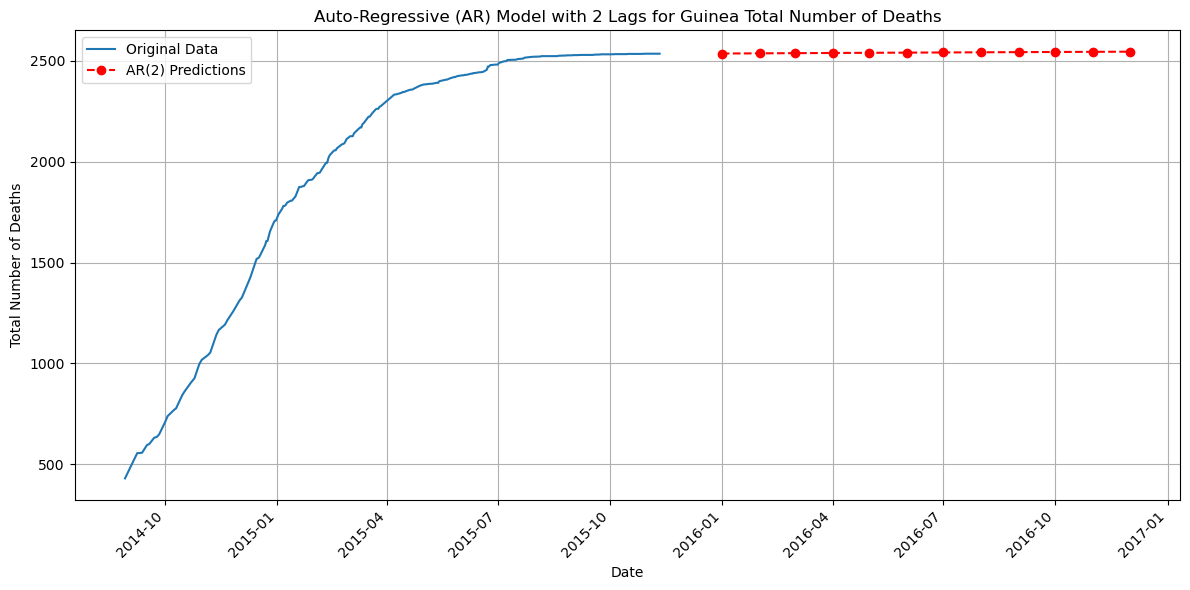

In [144]:
#Guinea AR Modeling: Monthly Death Cases
if 'Date' in guinea.columns:
    guinea['Date'] = pd.to_datetime(guinea['Date'], errors='coerce')
    guinea = guinea.dropna(subset=['Date'])
    guinea.set_index('Date', inplace=True)
guinea = guinea[guinea.index.year > 1970]
model_ar_g_deaths = AutoReg(guinea['Suspected/Confirmed/Probable Deaths'], lags=2)
model_ar_g_deaths_fit = model_ar_g_deaths.fit()

forecast_steps = 12
predictions_ar_g_deaths = model_ar_g_deaths_fit.predict(
    start=len(guinea), 
    end=len(guinea) + forecast_steps - 1
)
last_date_ar_g_deaths = pd.to_datetime(guinea.index[-1])
forecast_index_ar_g_deaths = pd.date_range(
    start=last_date_ar_g_deaths + pd.DateOffset(months=1), 
    periods=forecast_steps, 
    freq='MS'
)
plt.figure(figsize=(12, 6))
plt.plot(guinea.index, guinea['Suspected/Confirmed/Probable Deaths'], label='Original Data')
plt.plot(forecast_index_ar_g_deaths, predictions_ar_g_deaths, color='red', linestyle='dashed', marker='o', label='AR(2) Predictions')
plt.title('Auto-Regressive (AR) Model with 2 Lags for Guinea Total Number of Deaths')
plt.xlabel('Date')
plt.ylabel('Total Number of Deaths')
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

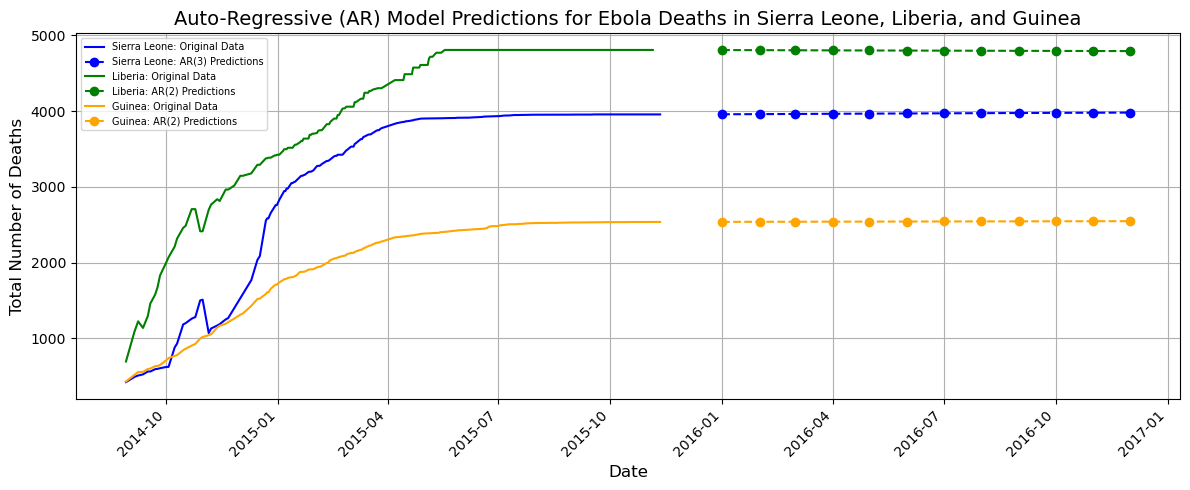

In [146]:
#Combined plot for all three AR models for Total Deaths
plt.figure(figsize=(12, 5))
plt.plot(sierra.index, sierra['Suspected/Confirmed/Probable Deaths'], label='Sierra Leone: Original Data', color='blue')
plt.plot(forecast_index_ar_s_deaths, predictions_ar_s_deaths, color='blue', linestyle='dashed', marker='o', label='Sierra Leone: AR(3) Predictions')
plt.plot(liberia.index, liberia['Suspected/Confirmed/Probable Deaths'], label='Liberia: Original Data', color='green')
plt.plot(forecast_index_ar_l_deaths, predictions_ar_l_deaths, color='green', linestyle='dashed', marker='o', label='Liberia: AR(2) Predictions')
plt.plot(guinea.index, guinea['Suspected/Confirmed/Probable Deaths'], label='Guinea: Original Data', color='orange')
plt.plot(forecast_index_ar_g_deaths, predictions_ar_g_deaths, color='orange', linestyle='dashed', marker='o', label='Guinea: AR(2) Predictions')
plt.title('Auto-Regressive (AR) Model Predictions for Ebola Deaths in Sierra Leone, Liberia, and Guinea', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Number of Deaths', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(loc='upper left', fontsize=7)
plt.grid()
plt.tight_layout()
plt.show()

$\textbf{Model Diagnostics for AR Total Deaths}$

In [198]:
#Residual Extractions
model_ar_s_deaths_fit_resid = model_ar_s_deaths_fit.resid
model_ar_l_deaths_fit_resid = model_ar_lib_deaths_fit.resid
model_ar_g_deaths_fit_resid = model_ar_g_deaths_fit.resid

In [200]:
#For Sierra Leone AR Model Diagnostics
print(acorr_ljungbox(model_ar_s_deaths_fit_resid, lags=[2], return_df=True)) #Autocorrelation Testing: No significant autocorrelated at tested lags
print(shapiro(model_ar_s_deaths_fit_resid)) #Normality Testing: Not normally distributed
print(het_breuschpagan(model_ar_s_deaths_fit_resid, sm.add_constant(model_ar_s_deaths_fit.fittedvalues))) #Presence of heteroscedasticity

    lb_stat  lb_pvalue
2  0.211115   0.899823
ShapiroResult(statistic=0.423736572265625, pvalue=6.330123044866645e-27)
(15.866743133394218, 6.796256379693898e-05, 16.86170903997899, 5.5514510720948304e-05)


In [202]:
#For Liberia AR Model Diagnostics
print(acorr_ljungbox(model_ar_l_deaths_fit_resid, lags=[2], return_df=True)) #Autocorrelation Testing: Significant autocorrelated at tested lags
print(shapiro(model_ar_l_deaths_fit_resid)) #Normality Testing: Not normally distributed
print(het_breuschpagan(model_ar_l_deaths_fit_resid, sm.add_constant(model_ar_lib_deaths_fit.fittedvalues))) #Presence of heteroscedasticity

     lb_stat  lb_pvalue
2  13.885133   0.000966
ShapiroResult(statistic=0.6750531196594238, pvalue=3.3340556319533714e-19)
(17.245964430410794, 3.2839432771548444e-05, 18.716875895074264, 2.4249638158805453e-05)


In [204]:
#For Guinea AR Model Diagnostics
print(acorr_ljungbox(model_ar_g_deaths_fit_resid, lags=[2], return_df=True)) #Autocorrelation Testing: No significant autocorrelated at tested lags
print(shapiro(model_ar_g_deaths_fit_resid)) #Normality Testing: Not normally distributed
print(het_breuschpagan(model_ar_g_deaths_fit_resid, sm.add_constant(model_ar_g_deaths_fit.fittedvalues))) #Presence of heteroscedasticity

    lb_stat  lb_pvalue
2  2.119711   0.346506
ShapiroResult(statistic=0.7049195766448975, pvalue=3.2074093041631305e-20)
(36.203839618141124, 1.7772005787350635e-09, 42.34028107231224, 4.549220392522069e-10)


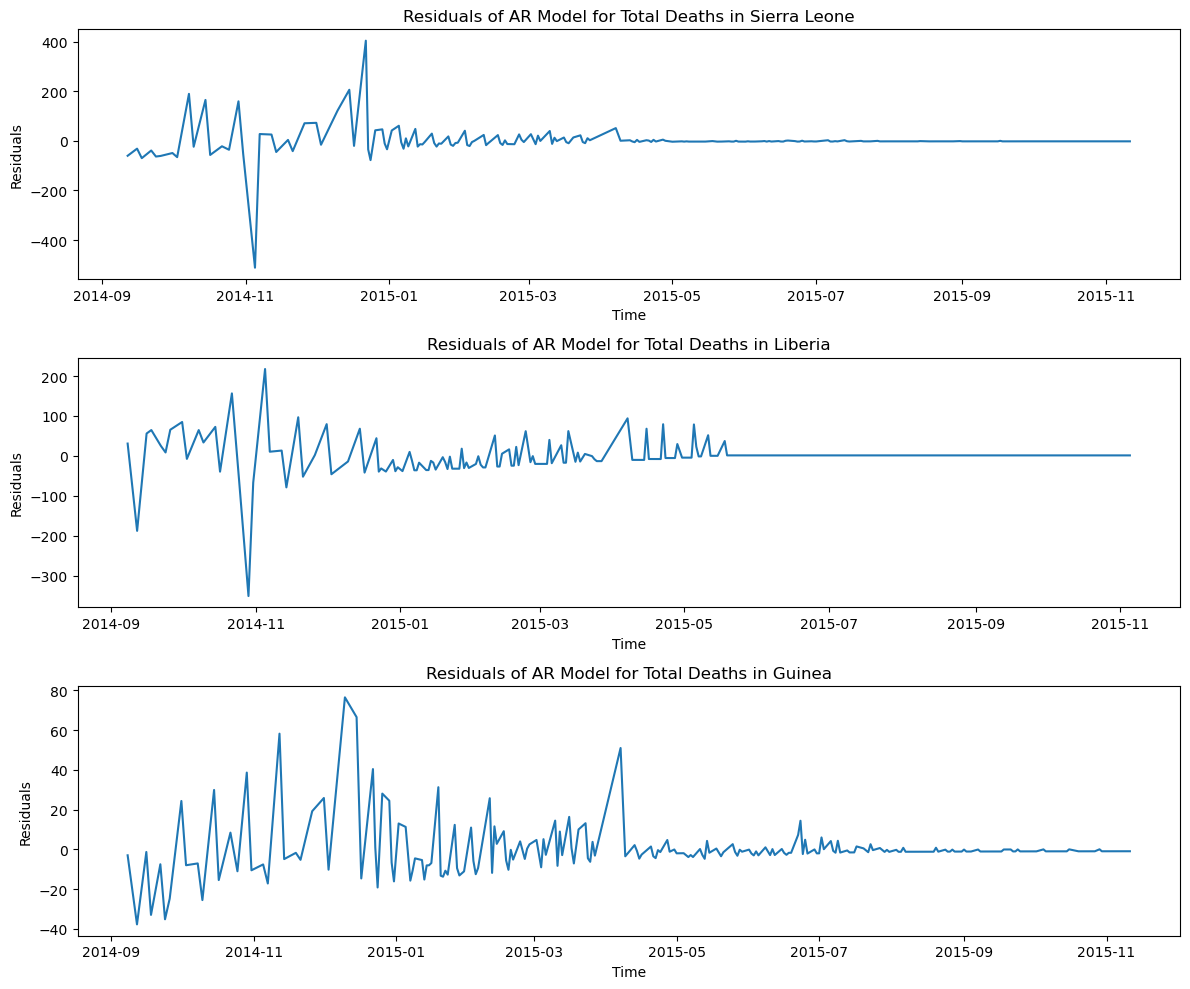

In [206]:
#Plotting Residuals
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
plt.plot(model_ar_s_deaths_fit_resid)
plt.title('Residuals of AR Model for Total Deaths in Sierra Leone')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.subplot(3, 1, 2)
plt.plot(model_ar_l_deaths_fit_resid)
plt.title('Residuals of AR Model for Total Deaths in Liberia')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.subplot(3, 1, 3)
plt.plot(model_ar_g_deaths_fit_resid)
plt.title('Residuals of AR Model for Total Deaths in Guinea')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

$\textbf{Auto Regressive Integrated Moving Average (ARIMA) and Auto Regressive Moving Average (ARMA) for Total Cases}$

Reference: https://builtin.com/data-science/time-series-forecasting-python


C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\User

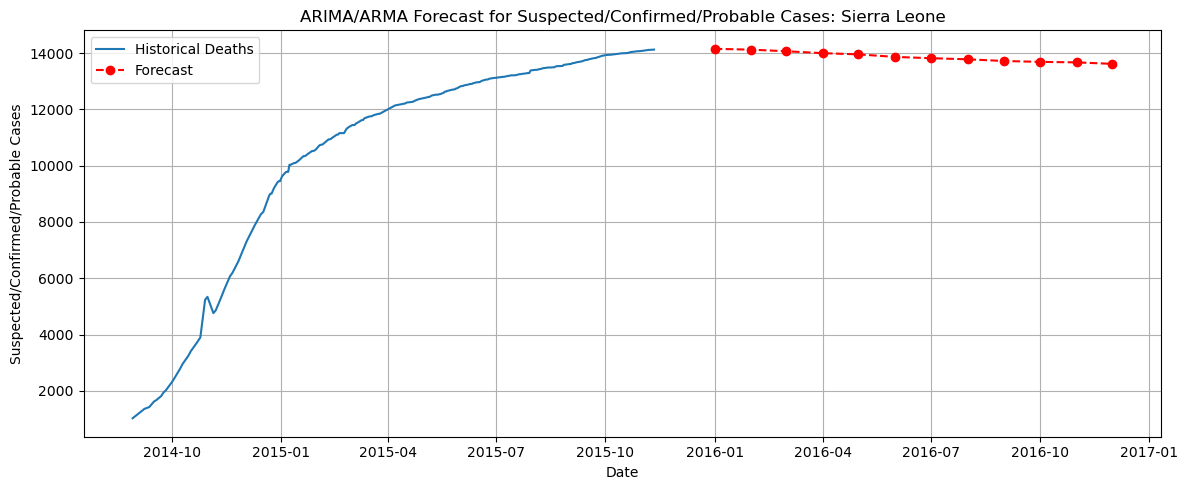

In [158]:
#For Sierra Leone Total Number of Cases
#2 for P based on PACF, d is set as 0 since the data is stationary after adf test and 16 based on ACf plot.
model_s_arima_cases = ARIMA(sierra['Suspected/Confirmed/Probable Cases'], order=(2, 0, 16)) 
model_s_arima_cases_fit = model_s_arima_cases.fit()
forecast_values_s_arima_cases = model_s_arima_cases_fit.forecast(steps=12)
forecast_index_s_arima_cases = pd.date_range(start=sierra.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
plt.figure(figsize=(12, 5))
plt.plot(sierra.index, sierra['Suspected/Confirmed/Probable Cases'], label='Historical Deaths')
plt.plot(forecast_index_s_arima_cases, forecast_values_s_arima_cases, color='red', marker='o', linestyle='dashed', label='Forecast')
plt.title('ARIMA/ARMA Forecast for Suspected/Confirmed/Probable Cases: Sierra Leone')
plt.xlabel('Date')
plt.ylabel('Suspected/Confirmed/Probable Cases')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

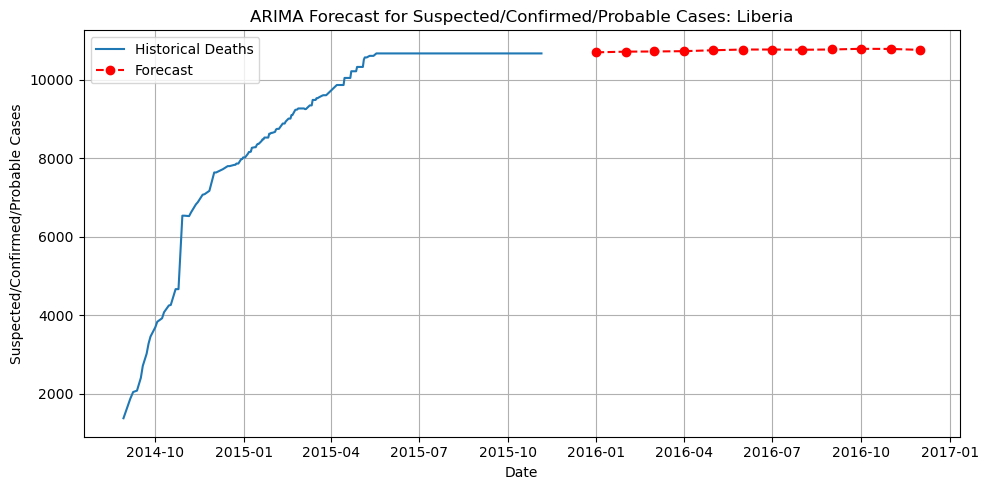

In [159]:
#For Liberia Mean Cases
#Same as Sierra Leone with 15 lags for q due to ACF plot.
model_l_arima_cases = ARIMA(liberia['Suspected/Confirmed/Probable Cases'], order=(3, 0, 15))
model_l_arima_cases_fit = model_l_arima_cases.fit()
forecast_values_l_arima_cases = model_l_arima_cases_fit.forecast(steps=12)
forecast_index_l_arima_cases = pd.date_range(start=liberia.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
plt.figure(figsize=(10, 5))
plt.plot(liberia.index, liberia['Suspected/Confirmed/Probable Cases'], label='Historical Deaths')
plt.plot(forecast_index_l_arima_cases, forecast_values_l_arima_cases, color='red', marker='o', linestyle='dashed', label='Forecast')
plt.title('ARIMA Forecast for Suspected/Confirmed/Probable Cases: Liberia')
plt.xlabel('Date')
plt.ylabel('Suspected/Confirmed/Probable Cases')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

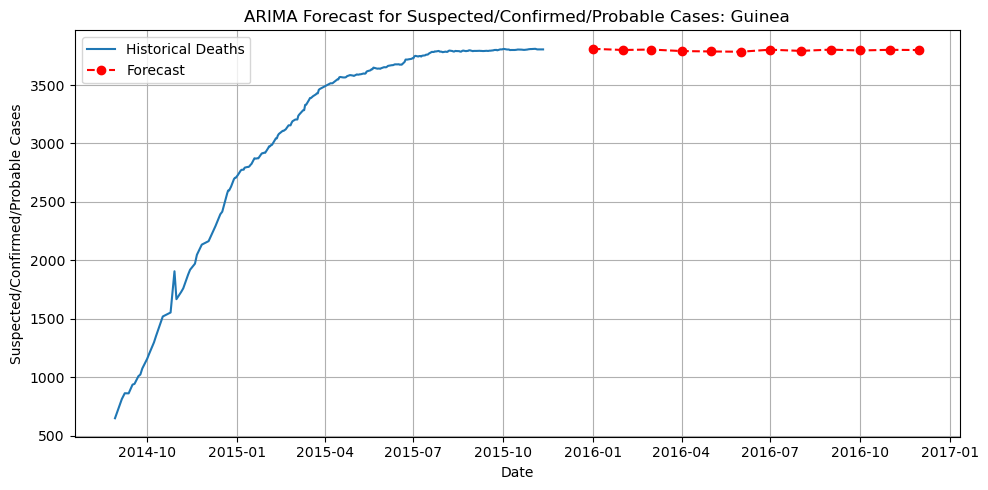

In [160]:
#For Guinea Total Cases
#Stationary thus d as 0, where ACF plot shows 17 lags so q as 17 and PACF plot shows p as 2.
model_g_arima_cases = ARIMA(guinea['Suspected/Confirmed/Probable Cases'], order=(2, 0, 17))
model_g_arima_cases_fit = model_g_arima_cases.fit()
forecast_values_g_arima_cases = model_g_arima_cases_fit.forecast(steps=12)
forecast_index_g_arima_cases = pd.date_range(start=guinea.index[-1] + pd.DateOffset(months=1), 
                                periods=12, freq='MS')
plt.figure(figsize=(10, 5))
plt.plot(guinea.index, guinea['Suspected/Confirmed/Probable Cases'], label='Historical Deaths')
plt.plot(forecast_index_g_arima_cases, forecast_values_g_arima_cases, color='red', marker='o', linestyle='dashed', label='Forecast')
plt.title('ARIMA Forecast for Suspected/Confirmed/Probable Cases: Guinea')
plt.xlabel('Date')
plt.ylabel('Suspected/Confirmed/Probable Cases')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

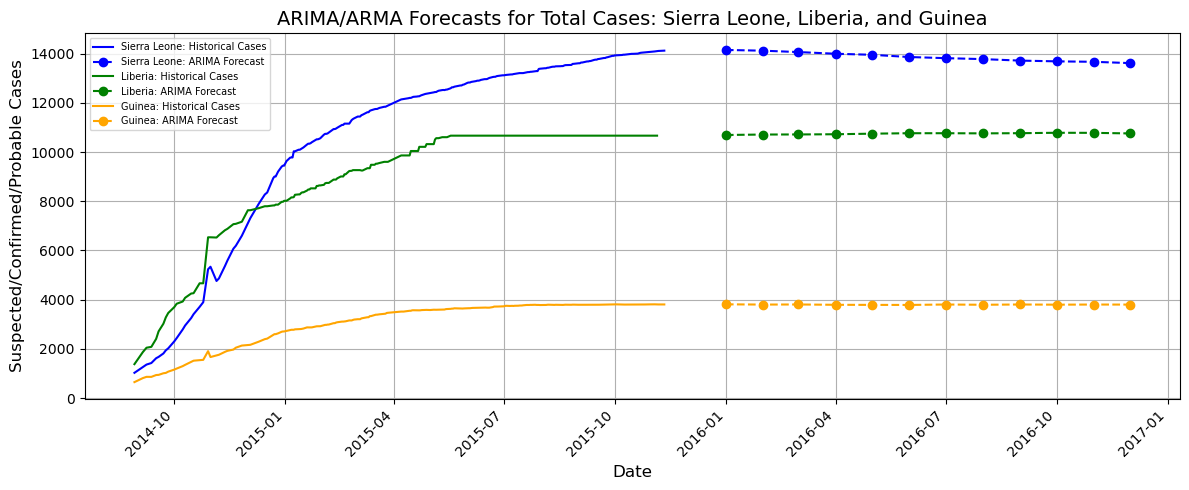

In [166]:
#Combined Plots for all ARIMA Total Cases
plt.figure(figsize=(12, 5))
plt.plot(sierra.index, sierra['Suspected/Confirmed/Probable Cases'], label='Sierra Leone: Historical Cases', color='blue')
plt.plot(forecast_index_s_arima_cases, forecast_values_s_arima_cases, color='blue', marker='o', linestyle='dashed', label='Sierra Leone: ARIMA Forecast')
plt.plot(liberia.index, liberia['Suspected/Confirmed/Probable Cases'], label='Liberia: Historical Cases', color='green')
plt.plot(forecast_index_l_arima_cases, forecast_values_l_arima_cases, color='green', marker='o', linestyle='dashed', label='Liberia: ARIMA Forecast')
plt.plot(guinea.index, guinea['Suspected/Confirmed/Probable Cases'], label='Guinea: Historical Cases', color='orange')
plt.plot(forecast_index_g_arima_cases, forecast_values_g_arima_cases, color='orange', marker='o', linestyle='dashed', label='Guinea: ARIMA Forecast')
plt.title('ARIMA/ARMA Forecasts for Total Cases: Sierra Leone, Liberia, and Guinea', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Suspected/Confirmed/Probable Cases', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(loc='upper left', fontsize=7)
plt.grid()
plt.tight_layout()
plt.show()

$\textbf{Model Diagnostics for ARIMA/ARMA Total Number of Cases}$

In [188]:
#Residual Extractions
model_s_arima_cases_resid = model_s_arima_cases_fit.resid
model_l_arima_cases_resid = model_l_arima_cases_fit.resid
model_g_arima_cases_resid = model_g_arima_cases_fit.resid

In [190]:
#For Sierra Leone ARIMA/ARMA Model Diagnostics
print(acorr_ljungbox(model_s_arima_cases_resid, lags=[2], return_df=True)) #Autocorrelation Testing: No significated autocorrelation at the tested lags
print(shapiro(model_s_arima_cases_resid)) #Normality Testing: Normally Distributed
print(het_breuschpagan(model_s_arima_cases_resid, sm.add_constant(model_s_arima_cases_fit.fittedvalues))) #Presence of heteroscedasticity

    lb_stat  lb_pvalue
2  0.134427   0.934995
ShapiroResult(statistic=0.12065470218658447, pvalue=6.893725999458058e-32)
(0.004159616216963258, 0.9485760191613417, 0.004125024242300346, 0.9488439062795372)


In [192]:
#For Liberia ARIMA/ARMA Model Diagnostics
print(acorr_ljungbox(model_l_arima_cases_resid, lags=[2], return_df=True)) #Autocorrelation Testing: No significated autocorrelation at the tested lags
print(shapiro(model_l_arima_cases_resid)) #Normality Testing: Normally Distributed
print(het_breuschpagan(model_l_arima_cases_resid, sm.add_constant(model_l_arima_cases_fit.fittedvalues))) #No heteroscedasticity

    lb_stat  lb_pvalue
2  0.630169   0.729727
ShapiroResult(statistic=0.1720784306526184, pvalue=1.0255355471918426e-28)
(0.024865190444391283, 0.8747034436357587, 0.02461711836584631, 0.8754863955707725)


In [194]:
#For Guinea ARIMA/ARMA Model Diagnostics
print(acorr_ljungbox(model_g_arima_cases_resid, lags=[2], return_df=True)) #Autocorrelation Testing: No significated autocorrelation at the tested lags
print(shapiro(model_g_arima_cases_resid)) #Normality Testing: Normally Distributed
print(het_breuschpagan(model_g_arima_cases_resid, sm.add_constant(model_g_arima_cases_fit.fittedvalues))) #No heteroscedasticity

   lb_stat  lb_pvalue
2  1.25712   0.533359
ShapiroResult(statistic=0.13367819786071777, pvalue=1.036116103194724e-31)
(0.0074005078786143486, 0.9314455861775005, 0.007339063282932158, 0.9318020997644116)


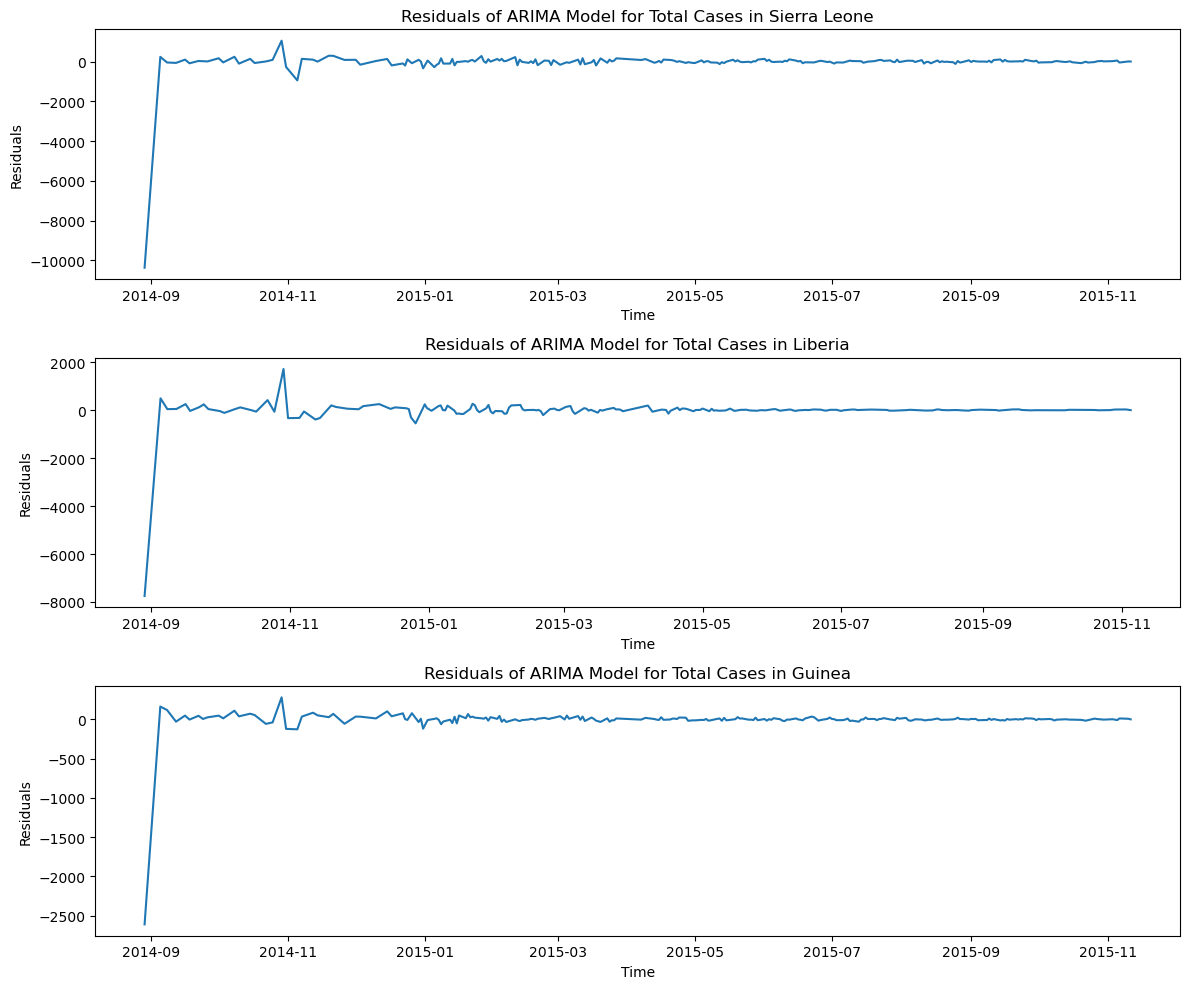

In [196]:
#Plotting residuals
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
plt.plot(model_s_arima_cases_resid)
plt.title('Residuals of ARIMA Model for Total Cases in Sierra Leone')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.subplot(3, 1, 2)
plt.plot(model_l_arima_cases_resid)
plt.title('Residuals of ARIMA Model for Total Cases in Liberia')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.subplot(3, 1, 3)
plt.plot(model_g_arima_cases_resid)
plt.title('Residuals of ARIMA Model for Total Cases in Guinea')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

$\textbf{Auto Regressive Integrated Moving Average (ARIMA) and Auto Regressive Moving Average (ARMA) for Total Deaths}$

C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\thumo\a

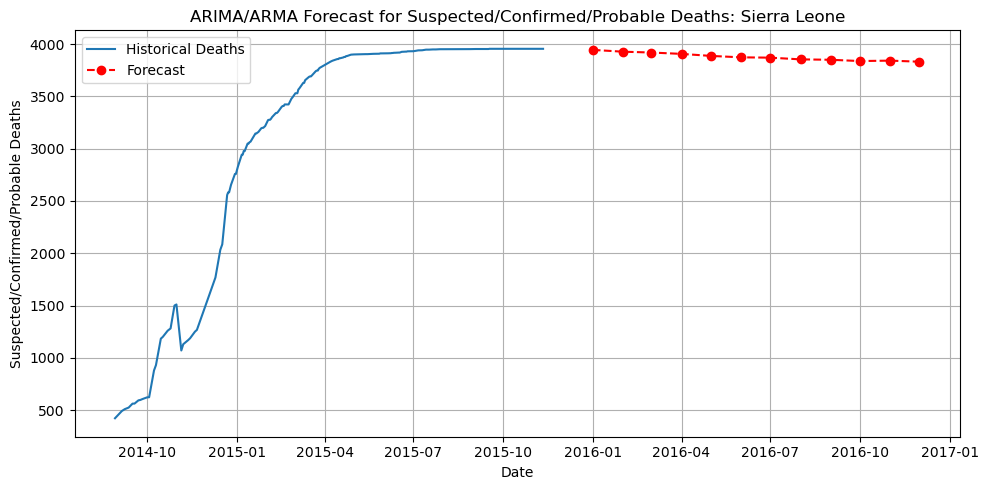

In [168]:
#Sierra Leone Total Deaths
#Stationary thus d is set as 0. p as 3 since PACF shows 3 lags and q as 17 since PACF shows 17 lags. 
s_model_arima_deaths = ARIMA(sierra['Suspected/Confirmed/Probable Deaths'], order=(3, 0, 17))
s_model_arima_deaths_fit = s_model_arima_deaths.fit()
forecast_values_s_arima_deaths = s_model_arima_deaths_fit.forecast(steps=12)
forecast_index_s_arima_deaths = pd.date_range(start=sierra.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
plt.figure(figsize=(10, 5))
plt.plot(sierra.index, sierra['Suspected/Confirmed/Probable Deaths'], label='Historical Deaths')
plt.plot(forecast_index_s_arima_deaths, forecast_values_s_arima_deaths, color='red', marker='o', linestyle='dashed', label='Forecast')
plt.title('ARIMA/ARMA Forecast for Suspected/Confirmed/Probable Deaths: Sierra Leone')
plt.xlabel('Date')
plt.ylabel('Suspected/Confirmed/Probable Deaths')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\thumo\a

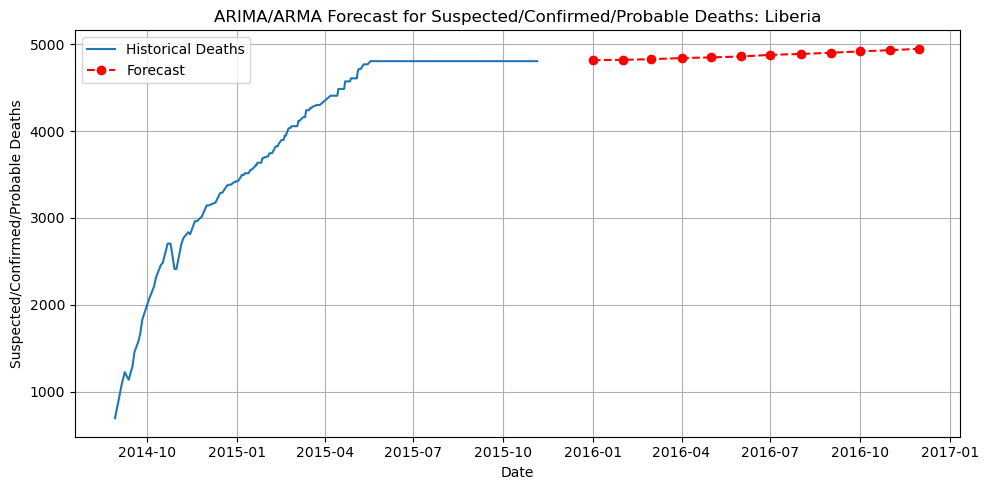

In [169]:
#For Liberia Total Deaths
#Non-stationary thus d is set as 1. p as 2 since PACF shows 2 lags and q as 15 since PACF shows 15 lags. 
lib_model_arima_deaths = ARIMA(liberia['Suspected/Confirmed/Probable Deaths'], order=(2, 1, 15))
lib_model_arima_deaths_fit = lib_model_arima_deaths.fit()
forecast_values_lib_arima_deaths = lib_model_arima_deaths_fit.forecast(steps=12)
forecast_index_lib_arima_deaths = pd.date_range(start=liberia.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
plt.figure(figsize=(10, 5))
plt.plot(liberia.index, liberia['Suspected/Confirmed/Probable Deaths'], label='Historical Deaths')
plt.plot(forecast_index_lib_arima_deaths, forecast_values_lib_arima_deaths, color='red', marker='o', linestyle='dashed', label='Forecast')
plt.title('ARIMA/ARMA Forecast for Suspected/Confirmed/Probable Deaths: Liberia')
plt.xlabel('Date')
plt.ylabel('Suspected/Confirmed/Probable Deaths')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\thumo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive pa

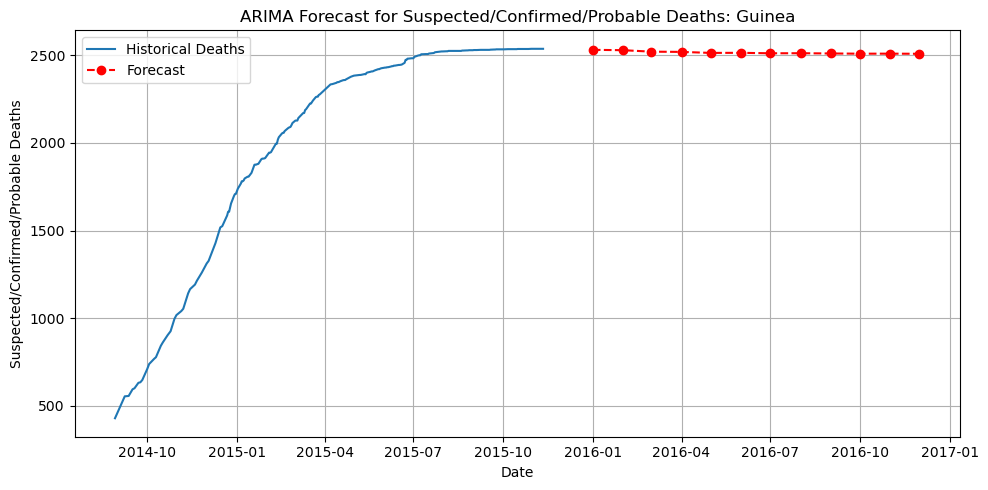

In [170]:
#For Guinea Monthly Total Deaths
#Stationary thus d is set as 0. p as 2 since PACF shows 2 lags and q as 18 since PACF shows 18 lags. 
g_model_arima_death = ARIMA(guinea['Suspected/Confirmed/Probable Deaths'], order=(2, 0, 18))
g_model_arima_death_fit = g_model_arima_death.fit()
forecast_values_g_arima_death = g_model_arima_death_fit.forecast(steps=12)
forecast_index_g_arima_death = pd.date_range(start=guinea.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
plt.figure(figsize=(10, 5))
plt.plot(guinea.index, guinea['Suspected/Confirmed/Probable Deaths'], label='Historical Deaths')
plt.plot(forecast_index_g_arima_death, forecast_values_g_arima_death, color='red', marker='o', linestyle='dashed', label='Forecast')
plt.title('ARIMA Forecast for Suspected/Confirmed/Probable Deaths: Guinea')
plt.xlabel('Date')
plt.ylabel('Suspected/Confirmed/Probable Deaths')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

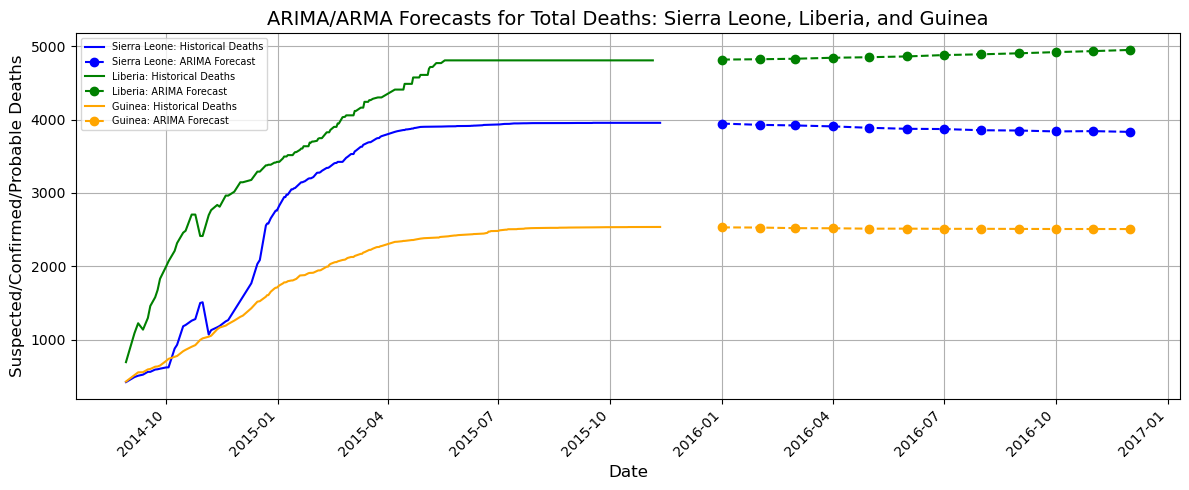

In [172]:
#Combined plots for all ARIMA Total Deaths
plt.figure(figsize=(12, 5))
plt.plot(sierra.index, sierra['Suspected/Confirmed/Probable Deaths'], label='Sierra Leone: Historical Deaths', color='blue')
plt.plot(forecast_index_s_arima_deaths, forecast_values_s_arima_deaths, color='blue', marker='o', linestyle='dashed', label='Sierra Leone: ARIMA Forecast')
plt.plot(liberia.index, liberia['Suspected/Confirmed/Probable Deaths'], label='Liberia: Historical Deaths', color='green')
plt.plot(forecast_index_lib_arima_deaths, forecast_values_lib_arima_deaths, color='green', marker='o', linestyle='dashed', label='Liberia: ARIMA Forecast')
plt.plot(guinea.index, guinea['Suspected/Confirmed/Probable Deaths'], label='Guinea: Historical Deaths', color='orange')
plt.plot(forecast_index_g_arima_death, forecast_values_g_arima_death, color='orange', marker='o', linestyle='dashed', label='Guinea: ARIMA Forecast')
plt.title('ARIMA/ARMA Forecasts for Total Deaths: Sierra Leone, Liberia, and Guinea', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Suspected/Confirmed/Probable Deaths', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(loc='upper left', fontsize=7)
plt.grid()
plt.tight_layout()
plt.show()

$\textbf{Model Diagnostics for ARIMA/ARMA Total Deaths}$

In [178]:
#Residual Extractions
s_model_arima_deaths_fit_resid = s_model_arima_deaths_fit.resid
l_model_arima_deaths_fit_resid = lib_model_arima_deaths_fit.resid
g_model_arima_deaths_fit_resid = g_model_arima_death_fit.resid

In [180]:
#For Sierra Leone ARIMA/ARMA Model Diagnostics
print(acorr_ljungbox(s_model_arima_deaths_fit_resid, lags=[2], return_df=True)) #Autocorrelation Testing: No significated autocorrelation at the tested lags
print(shapiro(s_model_arima_deaths_fit_resid)) #Normality Testing: Normally Distributed
print(het_breuschpagan(s_model_arima_deaths_fit_resid, sm.add_constant(s_model_arima_deaths_fit.fittedvalues))) #No heteroscedasticity

    lb_stat  lb_pvalue
2  0.121428   0.941092
ShapiroResult(statistic=0.15800756216049194, pvalue=2.247924178150919e-31)
(0.022713552790705194, 0.8802043570512567, 0.022526405078668692, 0.8808223100328058)


In [182]:
#For Liberia ARIMA/ARMA Model Diagnostics
print(acorr_ljungbox(l_model_arima_deaths_fit_resid, lags=[2], return_df=True)) #Autocorrelation Testing: No significated autocorrelation at the tested lags
print(shapiro(l_model_arima_deaths_fit_resid)) #Normality Testing: Normally Distributed
print(het_breuschpagan(l_model_arima_deaths_fit_resid, sm.add_constant(lib_model_arima_deaths_fit.fittedvalues))) #Presence of heteroscedasticity

    lb_stat  lb_pvalue
2  3.413719   0.181435
ShapiroResult(statistic=0.5660433769226074, pvalue=5.322813335776576e-22)
(34.43773193314179, 4.4010807340387255e-09, 41.26743617994297, 9.83940795498439e-10)


In [184]:
#For Guinea ARIMA/ARMA Model Diagnostics
print(acorr_ljungbox(g_model_arima_deaths_fit_resid, lags=[2], return_df=True)) #Autocorrelation Testing: No significated autocorrelation at the tested lags
print(shapiro(g_model_arima_deaths_fit_resid)) #Normality Testing: Normally Distributed
print(het_breuschpagan(g_model_arima_deaths_fit_resid, sm.add_constant(g_model_arima_death_fit.fittedvalues))) #No heteroscedasticity

   lb_stat  lb_pvalue
2  0.60731   0.738115
ShapiroResult(statistic=0.09829115867614746, pvalue=3.4629799088995655e-32)
(0.001474441800732862, 0.9693699880895902, 0.0014621637685486928, 0.9695297785063598)


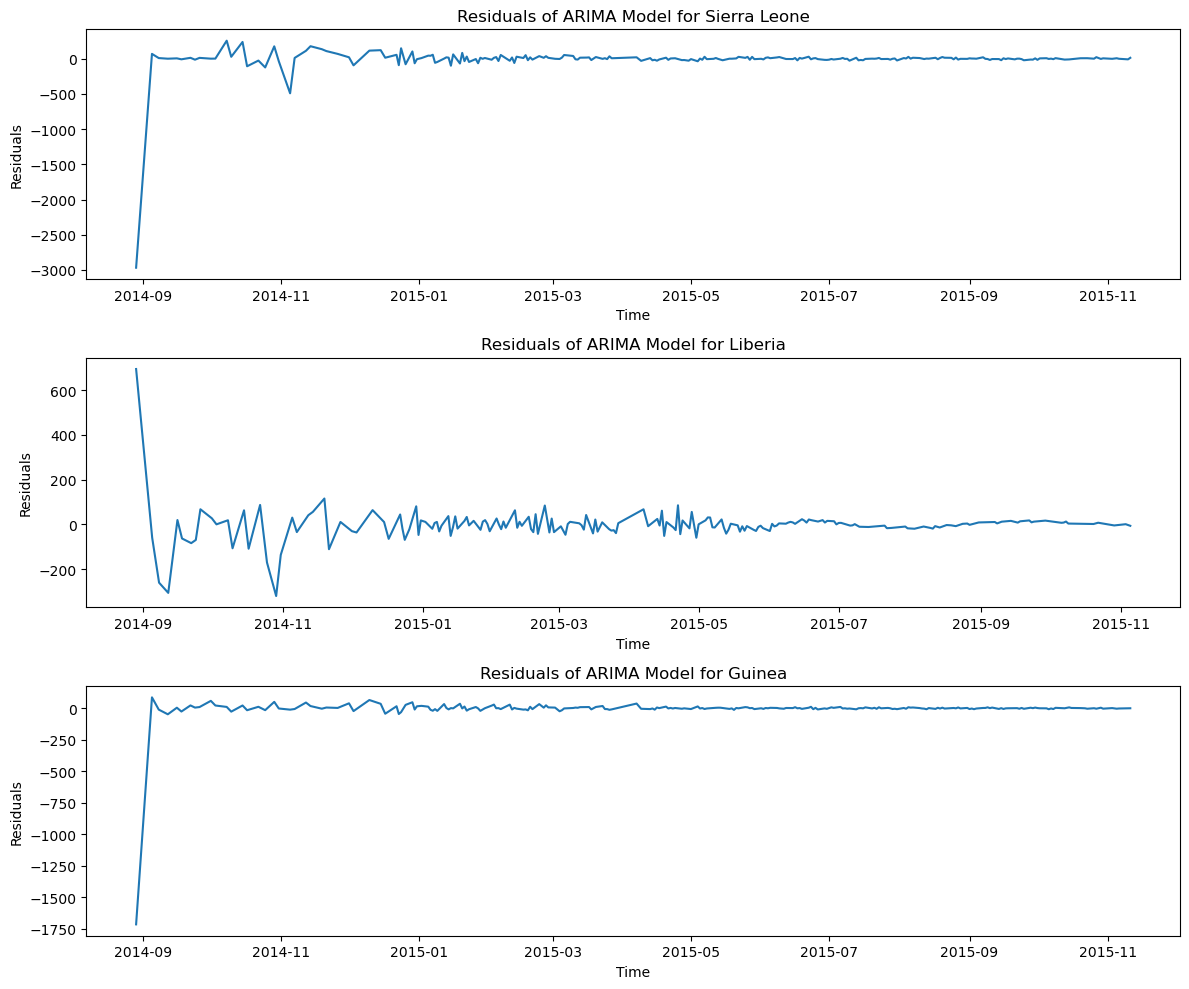

In [186]:
#Plotting Residuals
plt.figure(figsize=(12, 10))
plt.subplot(3, 1, 1)
plt.plot(s_model_arima_deaths_fit_resid)
plt.title('Residuals of ARIMA Model for Sierra Leone')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.subplot(3, 1, 2)
plt.plot(l_model_arima_deaths_fit_resid)
plt.title('Residuals of ARIMA Model for Liberia')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.subplot(3, 1, 3)
plt.plot(g_model_arima_deaths_fit_resid)
plt.title('Residuals of ARIMA Model for Guinea')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()